# Predicting saving behavior with demographic characteristics, psychological characteristics, and situational factors using machine learning models

### ------------------------------------------------------------Thesis in progress------------------------------------------------------------

### Student: Vitali Tsentsiper
### Supervisor: Guy Hochman
### Institution: Reichman University (IDC), M.A Behavioral Economics

### <u>Import libraries</u>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import miceforest as mf
import re

#EDA 
import sidetable
import missingno as msno
import shap
from yellowbrick.classifier import ROCAUC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

#ML
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

#Metrics classification
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics


#Error ignore
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

C:\Users\vital\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\vital\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\vital\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\vital\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
#Function that gets model, feature and target and plot precision recall curve
def pr_curve(model, features, target):
    y_pred_proba = model.predict_proba(features)
    
    Y = label_binarize(target, classes=[1, 2, 3, 4 ,5, 6, 7])
    
    n_classes = len(set(target))

    # precision recall curve
    precision = dict()
    recall = dict()
    plt.figure(figsize = (15,8))
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(Y[:, i], y_pred_proba[:, i])
        plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

    plt.xlabel("recall", size=15)
    plt.ylabel("precision", size=15)
    plt.legend(['0','$1-99','$100-999','$1,000-4,999','$5,000-19,999','$20,000-74,999','$75,000 or more'], loc="best")
    plt.title("precision vs. recall curve", size=20)
    plt.show()

In [3]:
#Visualization function for ROC AUC
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={1: '$0', 
                                        2: '$1-99', 
                                        3: '$100-999',
                                        4: '$1,000-4,999',
                                        5: '$5,000-19,999',
                                        6: '$20,000-74,999',
                                        7: '$75,000 or more'})
    
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

In [164]:
#Visualization function for ROC AUC for 3 classes
def plot_ROC_curve_3(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={1: 'Low', 
                                        2: 'Mid', 
                                        3: 'High'})
    
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

In [4]:
#Function that gets the pipeline, the parameters for pipeline and from GridSearcgCV, features train and target train
#and prints the best parameters, the best score and returns the best fitted model

def best_model(pipeline, parm, x_train, y_train):
    model_grid = GridSearchCV(pipeline, parm, cv=5, verbose=5, refit=True, scoring = 'f1_weighted',return_train_score=True)
    model_grid.fit(x_train, y_train)
    print()
    print('Best parameters:', model_grid.best_params_)
    print()
    print('Best score:', round(model_grid.best_score_,2))
    return model_grid

In [5]:
#Function that gets the pipeline, the parameters for pipeline and from GridSearcgCV, features train and target train
#and prints the best parameters, the best score and returns the best fitted model

def best_model_binary(pipeline, parm, x_train, y_train):
    model_grid = GridSearchCV(pipeline, parm, cv=5, verbose=5, refit=True, scoring = 'f1',return_train_score=True)
    model_grid.fit(x_train, y_train)
    print()
    print('Best parameters:', model_grid.best_params_)
    print()
    print('Best score:', round(model_grid.best_score_,2))
    return model_grid

## Part I - preprocessing the data

### <u>Plan</u>

1. Load the original data set
2. Keep only features without data leakedge and replace their names into meaningful names
4. Replaced non answered questions with NaN
3. Remove unvalid target variables
6. Check for corerlations between features
3. Split the data into train and test sets
5. Impute missing values

In [6]:
original_data = pd.read_csv('C:/My files/Thesis/Data sets/1 - Financial survey/1 - NFWBS_PUF_2016_data.csv')

In [7]:
#See the data
original_data.head()

PUF_ID  sample  fpl  SWB_1  SWB_2  SWB_3  FWBscore  FWB1_1  FWB1_2  FWB1_3  \
0   10350       2    3      5      5      6        55       3       3       3   
1    7740       1    3      6      6      6        51       2       2       3   
2   13699       1    3      4      3      4        49       3       3       3   
3    7267       1    3      6      6      6        49       3       3       3   
4    7375       1    3      4      4      4        49       3       3       3   

   ...  PPMSACAT  PPREG4  PPREG9  PPT01  PPT25  PPT612  PPT1317  PPT18OV  \
0  ...         1       4       8      0      0       0        0        1   
1  ...         1       2       3      0      0       0        0        2   
2  ...         1       4       9      0      0       0        1        2   
3  ...         1       3       7      0      0       0        0        1   
4  ...         1       2       4      0      0       1        0        4   

   PCTLT200FPL   finalwt  
0            0  0.367292  
1            0  1.327561  
2            1  0.835156  
3            0  1.410871  
4            1  4.260668  

[5 rows x 217 columns]

In [8]:
#Data size
original_data.shape

(6394, 217)

In [9]:
#Upload file with the columns we want to keep and meaningful names 
col_names = pd.read_csv('C:/My files/Thesis/Data sets/1 - Financial survey/columns for ML.csv', encoding='cp1252')

In [10]:
col_names.head()

Variable Name                                   Variables for ML
0         SWB_1                        I am satisfied with my life
1         SWB_2                    I am optimistic about my future
2         SWB_3  If I work hard today, I will be more successfu...
3        FWB2_4                        My finances control my life
4         FS1_1  I know how to get myself to follow through on ...

In [11]:
#Make list of used variables - original names
variables = list(col_names['Variable Name'])

In [12]:
#Keep only wanted features, without data leakege
data_upd = original_data[variables]

In [13]:
data_upd.head()

SWB_1  SWB_2  SWB_3  FWB2_4  FS1_1  FS1_2  FS1_3  FS1_4  FS1_5  FS1_6  ...  \
0      5      5      6       4      3      3      4      3      3      3  ...   
1      6      6      6       3      3      3      3      3      4      3  ...   
2      4      3      4       3      3      3      3      3      3      3  ...   
3      6      6      6       3      3      3      3      3      3      3  ...   
4      4      4      4       3      3      3      3      3      3      3  ...   

   PPHHSIZE  PPINCIMP  PPMARIT  PPREG4  PPREG9  PPT01  PPT25  PPT612  PPT1317  \
0         1         7        3       4       8      0      0       0        0   
1         2         6        3       2       3      0      0       0        0   
2         3         6        3       4       9      0      0       0        1   
3         1         8        3       3       7      0      0       0        0   
4         5         7        1       2       4      0      0       1        0   

   PPT18OV  
0        1  
1        2  
2        2  
3        1  
4        4  

[5 rows x 161 columns]

We kept 161 columns

In [14]:
data_upd.shape

(6394, 161)

In [15]:
#Make list of used meaningful names
names = list(col_names['Variables for ML'])

In [16]:
#Create dictinary
col_rename_dict = {i:j for i,j in zip(variables,names)}

#Update names
data_upd = data_upd.rename(columns=col_rename_dict)

In [17]:
data_upd.head()

I am satisfied with my life  I am optimistic about my future  \
0                            5                                5   
1                            6                                6   
2                            4                                3   
3                            6                                6   
4                            4                                4   

   If I work hard today, I will be more successful in the future  \
0                                                  6               
1                                                  6               
2                                                  4               
3                                                  6               
4                                                  4               

   My finances control my life  \
0                            4   
1                            3   
2                            3   
3                            3   
4                            3   

   I know how to get myself to follow through on my financial intentions  \
0                                                  3                       
1                                                  3                       
2                                                  3                       
3                                                  3                       
4                                                  3                       

   I know where to find the advice I need to make decisions involving money  \
0                                                  3                          
1                                                  3                          
2                                                  3                          
3                                                  3                          
4                                                  3                          

   I know how to make complex financial decisions  \
0                                               4   
1                                               3   
2                                               3   
3                                               3   
4                                               3   

   I am able to make good financial decisions that are new to me  \
0                                                  3               
1                                                  3               
2                                                  3               
3                                                  3               
4                                                  3               

   I am able to recognize a good financial investment  \
0                                                  3    
1                                                  4    
2                                                  3    
3                                                  3    
4                                                  3    

   I know how to keep myself from spending too much  ...  Household Size  \
0                                                 3  ...               1   
1                                                 3  ...               2   
2                                                 3  ...               3   
3                                                 3  ...               1   
4                                                 3  ...               5   

   Household Income  Marital Status  Census Region  Census Division  \
0                 7               3              4                8   
1                 6               3              2                3   
2                 6               3              4                9   
3                 8               3              3                7   
4                 7               1              2                4   

   Presence of Household Members - Children 0-1  \
0                                             0 

## EDA

EDA - Exploratory data analysis to recognize patterns and see trends. As we are not trying to find causality we won't be able to say whether change in savings is due to financial behavior, or larger amount of savings enables better financial behavior. We are relying on literature to understand this behavior.

In [18]:
# Change "How much money do you have in savings today...?" to "target"
data_upd.rename(columns={'How much money do you have in savings today...?': 'target'},inplace=True)

In [19]:
#See what values we see in the target variables
data_upd['target'].value_counts()

 5     1093
 99     988
 4      931
 6      845
 7      834
 3      682
 1      440
 2      385
 98     158
-1       38
Name: target, dtype: int64

99 Prefer not to say<br>
98 I don't know<br>
-1 Refused<br>
-2 Question not asked because respondent not in item base<br>
-3 Invalid response<br>
-4 Response not written to database<br>
-5 County not known<br>

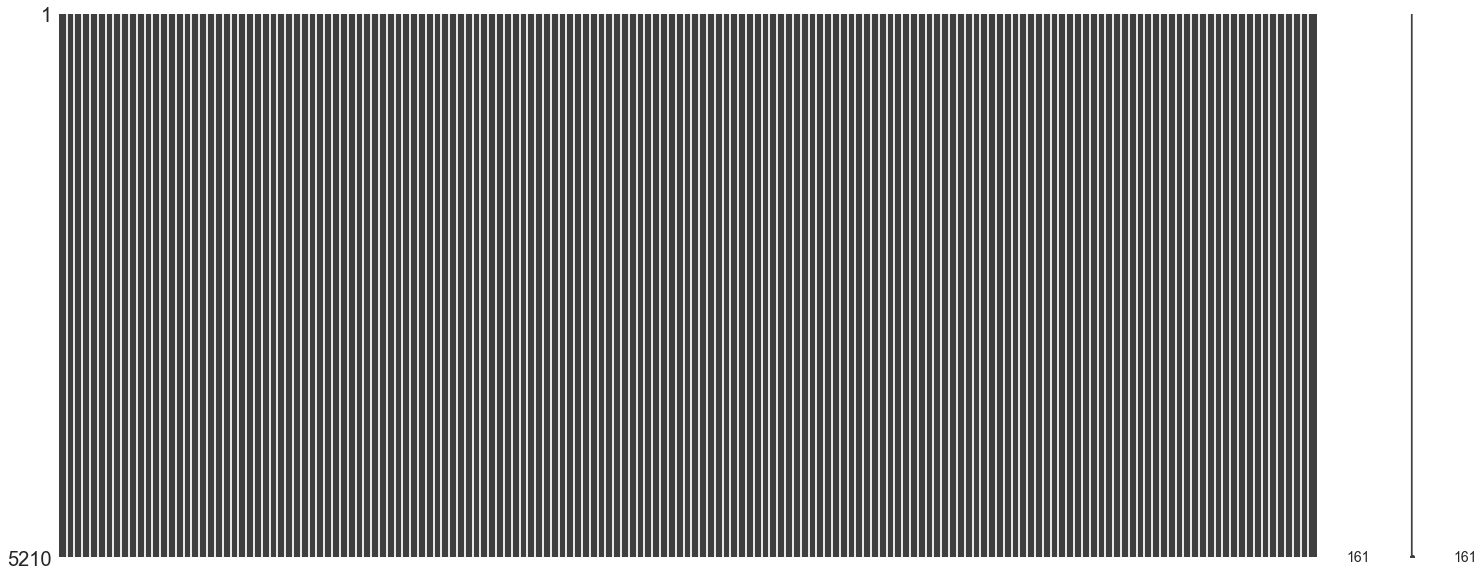

In [20]:
#Replace the unwanted answers with NaN
data_upd['target'] = data_upd['target'].replace([99,98,-1,-2, -3,-4,-5], np.nan)

#Drop NaN in target
data_final = data_upd.dropna(subset=['target'])


#See missing values
msno.matrix(data_final);

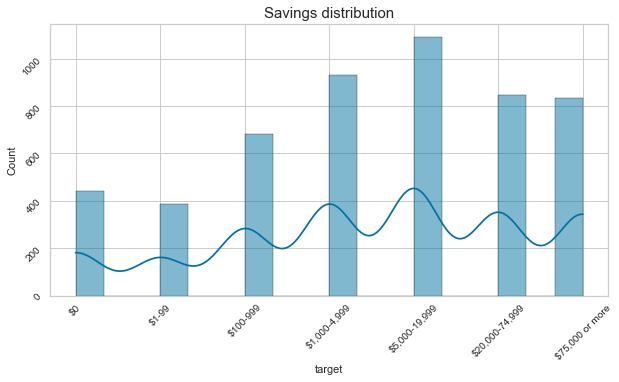

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data_upd['target'], kde=True, ax=ax)
ax.set_xticks(range(1,8))
ax.set_xticklabels(['$0','$1-99','$100-999','$1,000-4,999','$5,000-19,999','$20,000-74,999','$75,000 or more'])
ax.tick_params(rotation=45)
plt.title('Savings distribution', size=15)
plt.show()

### Income

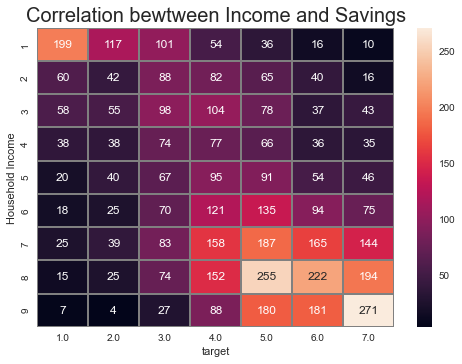

In [22]:
sns.heatmap(data_upd.groupby(['Household Income','target'])['target'].count().unstack(),
            linewidths=.01,linecolor='gray',annot=True,fmt='g')
           
plt.title('Correlation bewtween Income and Savings', size=20)
plt.show()

We see clear patternt between households income and savings amounts.

### Age

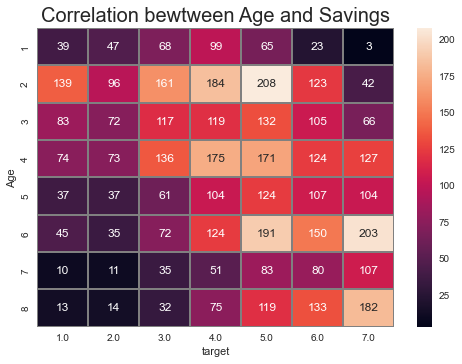

In [23]:
sns.heatmap(data_upd.groupby(['Age','target'])['target'].count().unstack(),
            linewidths=.01,linecolor='gray',annot=True,fmt='g')
           
plt.title('Correlation bewtween Age and Savings', size=20)
plt.show()

Age is much less correlated with savings, but we can see some wide trend.

In [24]:
#Look for column name with credit:
[col for col in data_upd.columns if 'credit' in col]

['Paid off credit card balance in full each month',
 'actual understanding of credit card minimum payments',
 'Checking or Savings Account at a bank or credit union',
 'Discussed how to establish a good credit rating']

## Purchase behavior

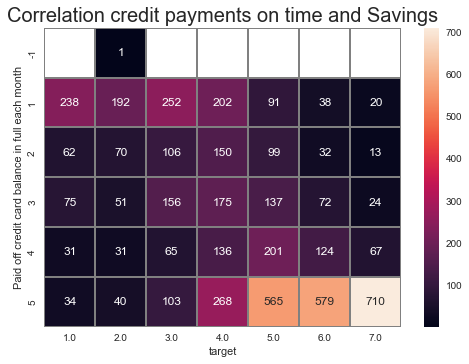

In [25]:
sns.heatmap(data_upd.groupby(['Paid off credit card balance in full each month','target'])['target'].count().unstack(),
            linewidths=.01,linecolor='gray',annot=True,fmt='g')
           
plt.title('Correlation credit payments on time and Savings', size=20)
plt.show()

We see strong patterns for edges - people never pay credit on time (1) typically have less savings, while poeple who always pay on time (5) typically have high savings.

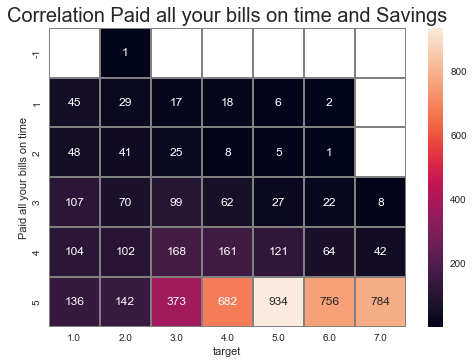

In [26]:
sns.heatmap(data_upd.groupby(['Paid all your bills on time','target'])['target'].count().unstack(),
            linewidths=.01,linecolor='gray',annot=True,fmt='g')
           
plt.title('Correlation Paid all your bills on time and Savings', size=20)
plt.show()

### Planning horizon

In [27]:
#Look for column name with credit:
[col for col in data_upd.columns if 'hori' in col]

['Financial planning time horizon']

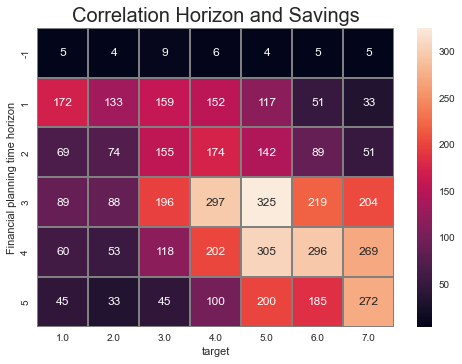

In [28]:
sns.heatmap(data_upd.groupby(['Financial planning time horizon','target'])['target'].count().unstack(),
            linewidths=.01,linecolor='gray',annot=True,fmt='g')
           
plt.title('Correlation Horizon and Savings', size=20)
plt.show()

Also here we see the paternt of higher horizon correlated with higher savings.

We see that people who paid all bills on time have more savings.

### Income volatility (uncertainity)

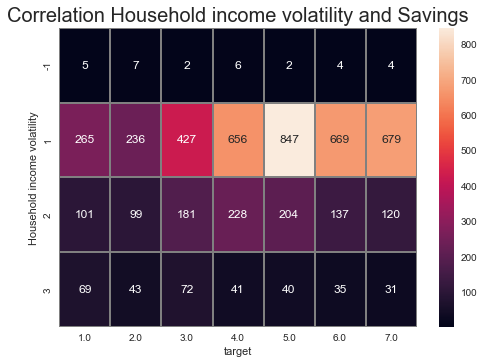

In [29]:
sns.heatmap(data_upd.groupby(['Household income volatility','target'])['target'].count().unstack(),
            linewidths=.01,linecolor='gray',annot=True,fmt='g')
           
plt.title('Correlation Household income volatility and Savings', size=20)
plt.show()

We see that most of the participents have low income volaitlity, but it seems that people with high income volatility have less savings.

### Materialism

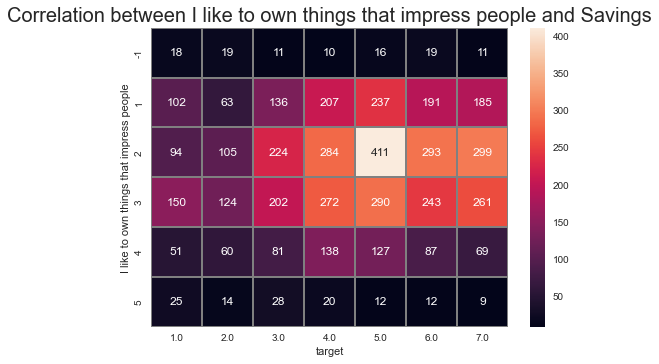

In [30]:
sns.heatmap(data_upd.groupby(['I like to own things that impress people','target'])['target'].count().unstack(),
            linewidths=.01,linecolor='gray',annot=True,fmt='g')
           
plt.title('Correlation between I like to own things that impress people and Savings', size=20)
plt.show()

We see that people who are strongly agree with this statment ("I like to own things that impress people") have less savings.

In [31]:
#Look for column name with credit:
[col for col in data_upd.columns if 'The things I own' in col]

['The things I own say a lot about how well I’m doing in life']

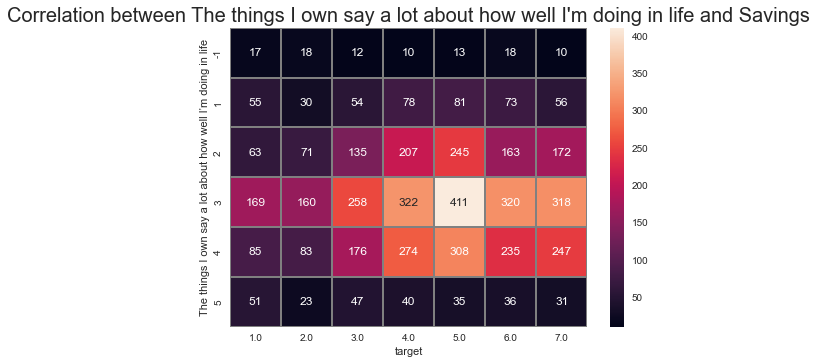

In [32]:
sns.heatmap(data_upd.groupby(["The things I own say a lot about how well I’m doing in life",'target'])['target'].count().unstack(),
            linewidths=.01,linecolor='gray',annot=True,fmt='g')
           
plt.title("Correlation between The things I own say a lot about how well I'm doing in life and Savings", size=20)
plt.show()

Also here, people who strongly agree with materialism have less savings, althog seems that people who agree, tend to have more savings. This statment might be just a reasonable statement and not how people live the statement above.

### Locus of control

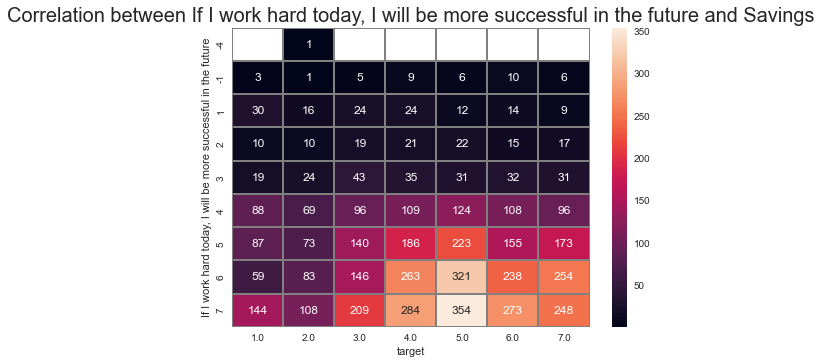

In [33]:
sns.heatmap(data_upd.groupby(["If I work hard today, I will be more successful in the future",'target'])['target'].count().unstack(),
            linewidths=.01,linecolor='gray',annot=True,fmt='g')
           
plt.title("Correlation between If I work hard today, I will be more successful in the future and Savings", size=20)
plt.show()

We see high correlation between people who belive in their hard work and savings amount.

### Unemployment situation

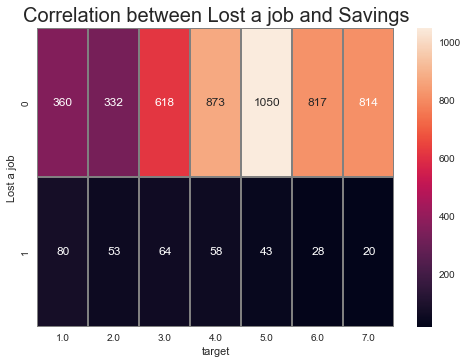

In [34]:
sns.heatmap(data_upd.groupby(["Lost a job",'target'])['target'].count().unstack(),
            linewidths=.01,linecolor='gray',annot=True,fmt='g')
           
plt.title("Correlation between Lost a job and Savings", size=20)
plt.show()

We see that people who had unemployment shock in the last year have less savings, altough they are small portion of the sample.

# Initial model experiment

First we will try to predict the target with the unwanted valuse, as they are represented in very specific coding:<br>
    
99 Prefer not to say<br>
98 I don't know<br>
-1 Refused<br>
-2 Question not asked because respondent not in item base<br>
-3 Invalid response<br>
-4 Response not written to database<br>
-5 County not known<br>

In [35]:
data_final.shape

(5210, 161)

In [36]:
print('We droped',len(original_data) - len(data_final),'observations with unvalid answers')

We droped 1184 observations with unvalid answers


### Check correlations

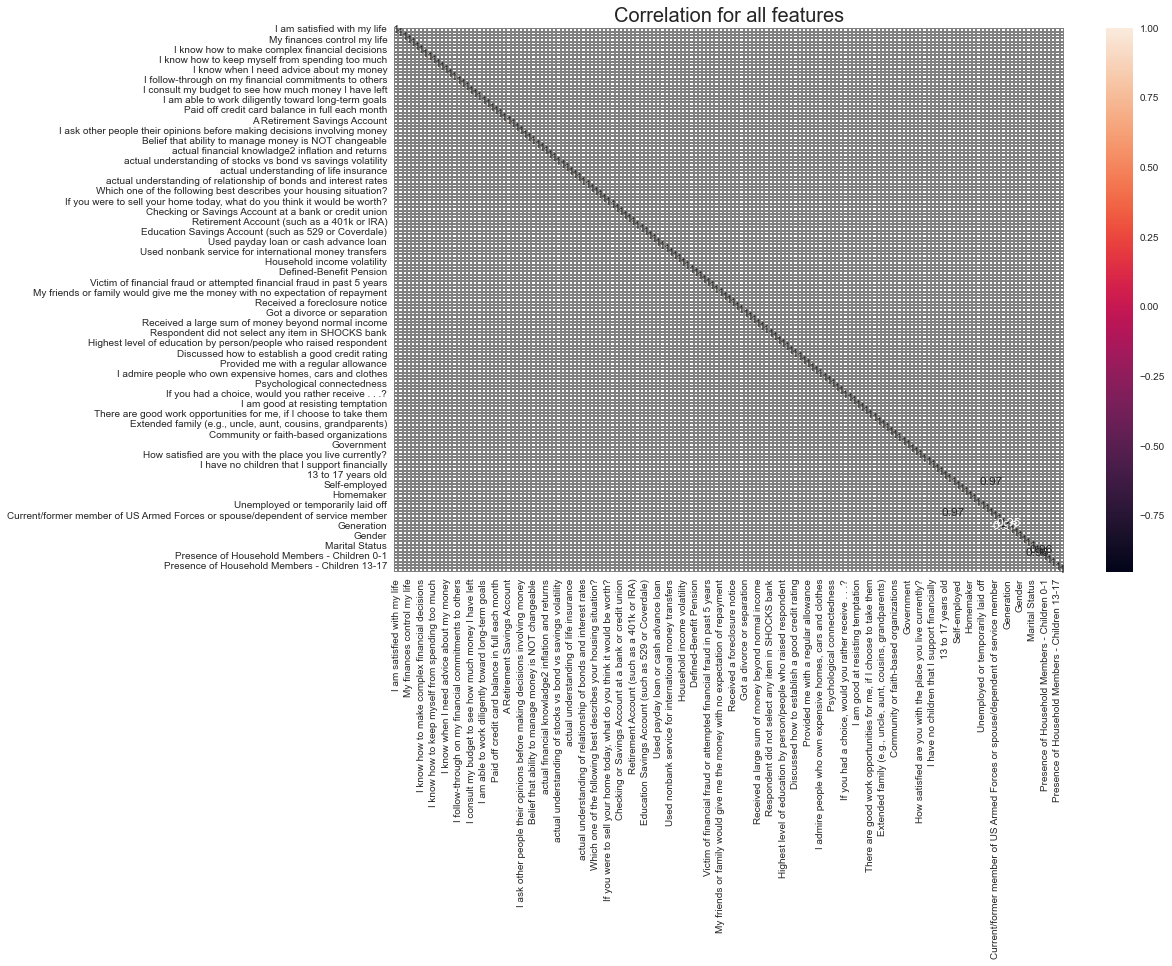

In [37]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(data_final.corr()[(data_final.corr()>0.9) | (data_final.corr()<-0.9)], ax=ax, 
            linewidths=.01,linecolor='gray',annot=True)
plt.title('Correlation for all features', size=20)
plt.show()

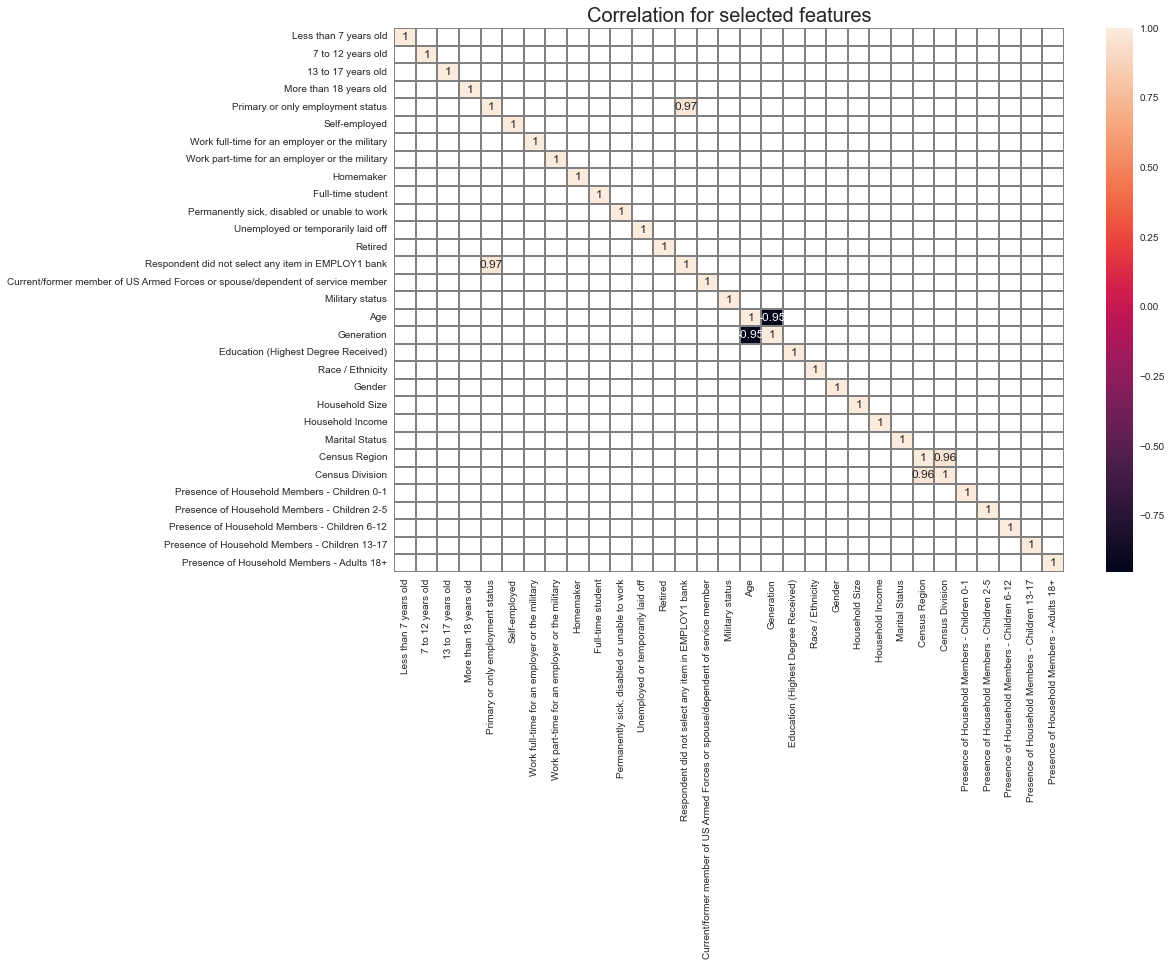

In [38]:
#Zoom in
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(data_final[data_final.columns[130:162]].corr()[(data_final[data_final.columns[130:162]].corr()>0.9) | (data_final[data_final.columns[130:162]].corr()<-0.9)], ax=ax, 
            linewidths=.01,linecolor='gray',annot=True)
plt.title('Correlation for selected features', size=20)
plt.show()

We see high correlation between:<br>
1. Work status not reported and Primary or only employment status: 97%. Work status are question asked and recorded as dummy variables which are later converted into new columns - Primary or only employment status. Work status questions should be removed.
2. Age and Generation: -95%. Age categories are represented by generation. We can remove this column without loosing any new infornation.
3. Census region and census division 96%. Division is more elaborated variable. Census region should be removed.

In [39]:
#Remove correlated file
data_final.drop(['Primary or only employment status','Self-employed','Work full-time for an employer or the military',
                 'Work part-time for an employer or the military','Homemaker','Full-time student',
                'Permanently sick, disabled or unable to work','Unemployed or temporarily laid off',
                'Retired','Respondent did not select any item in EMPLOY1 bank','Generation', 'Census Region'], axis=1, inplace=True)

### Split the data

We will split the data into train (80%) and test (20%) sets and run cross validation on the train set.

In [40]:
target_all = data_final['target']
features_all = data_final.drop(['target'], axis=1)

#split into 80% (will be used with cross validation) train and 20% test
features_train_all, features_test_all, target_train_all, target_test_all = train_test_split(features_all, target_all, test_size=0.2, random_state=42)

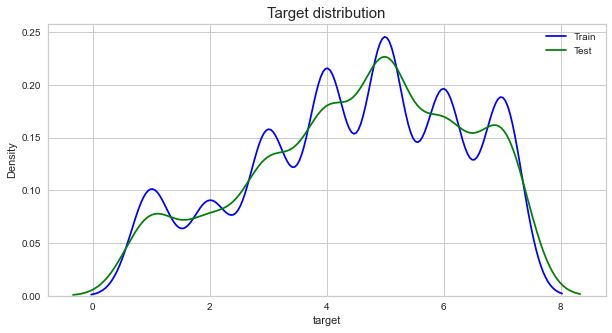

In [41]:
#See target distribution between groups

fig, axs = plt.subplots(figsize=(10, 5))
sns.kdeplot(data=target_train_all, ax=axs, color='blue', label='Train')
sns.kdeplot(data=target_test_all, ax=axs, color='green', label='Test')
plt.title('Target distribution', size=15)
plt.legend()
plt.show()

Our data is not balanced but normaly distributed, there is no clear majority/minority group.

### Random Forest

In [42]:
rf = RandomForestClassifier(random_state=42)
rf.fit(features_train_all, target_train_all)

RandomForestClassifier(random_state=42)

In [43]:
y_pred_full = rf.predict(features_test_all)

In [44]:
print(classification_report(target_test_all, y_pred_full, target_names=['0','$1-99','$100-999','$1,000-4,999',
                                                               '$5,000-19,999','$20,000-74,999','$75,000 or more']))

                 precision    recall  f1-score   support

              0       0.42      0.48      0.45        83
          $1-99       0.15      0.05      0.08        74
       $100-999       0.28      0.26      0.27       133
   $1,000-4,999       0.34      0.42      0.38       180
  $5,000-19,999       0.35      0.41      0.38       236
 $20,000-74,999       0.31      0.20      0.24       165
$75,000 or more       0.46      0.54      0.50       171

       accuracy                           0.36      1042
      macro avg       0.33      0.34      0.33      1042
   weighted avg       0.34      0.36      0.35      1042



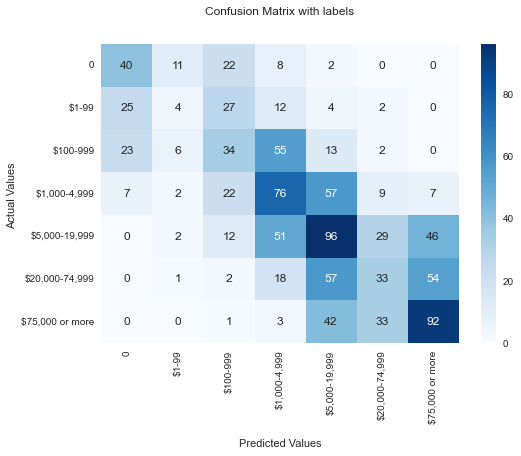

In [45]:
#confusion_matrix
conf= confusion_matrix(target_test_all, y_pred_full)

ax = sns.heatmap(conf, annot=True, cmap='Blues',fmt='g')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.set_xticklabels(['0','$1-99','$100-999','$1,000-4,999','$5,000-19,999','$20,000-74,999','$75,000 or more'])
ax.set_yticklabels(['0','$1-99','$100-999','$1,000-4,999','$5,000-19,999','$20,000-74,999','$75,000 or more'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

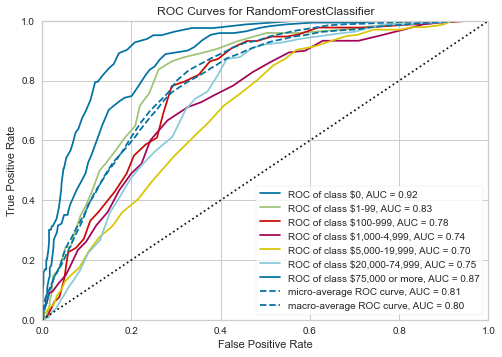

In [46]:
visual_1 = plot_ROC_curve(rf, features_train_all, target_train_all, features_test_all, target_test_all)

Separability of the classes by all possible thresholds - how good the classes can be separated using their predicted probabilities. If most of my 1 classes have the probability of 95%, and all 0 classes have 100-95%=5%, the AUC will be very high. If on the other hand we have large range of probabilities to 1 and 0, the AUC will be low.

**TPR (True Positive Rate) / Recall /Sensitivity**: TP/(TP+FN) <br>
What is the rate of true positive of all actual positive. If we class all into 1, we will have 100% TPR, because we will have no FN, we won't class anything to negative. But we will have many false positive.<br>

**FPR (False Positive Rate)**: FP/(TP+FP)<br>
What is the rate of false positive of all predicted positive.<br>

**Precision**: TP/(TP+FP). Predicted correctly true positive out of all predictions of true positive.<br>

OVR - One vs Rest methodology: When AUC is 0.92, it means there is a 92% chance that the model will be able to distinguish between a class vs all others.<br>

The ROC AUC exemines what would happened if I change the treshold to all possible probabilities.

We use it when we want to rank predictions.

**Can't be used when the data is imbalanced as false positive will be pulled down due to large number of true negative - mosre data will be labled as negative and because it is imbalanced it will be correct. In our case One vs Rest is highly imbalanced what makes the results seem to be better than they are. The curve shows us how good the clasiffier would work if it was binary in different tresholds.**

### Precision Recall Curve

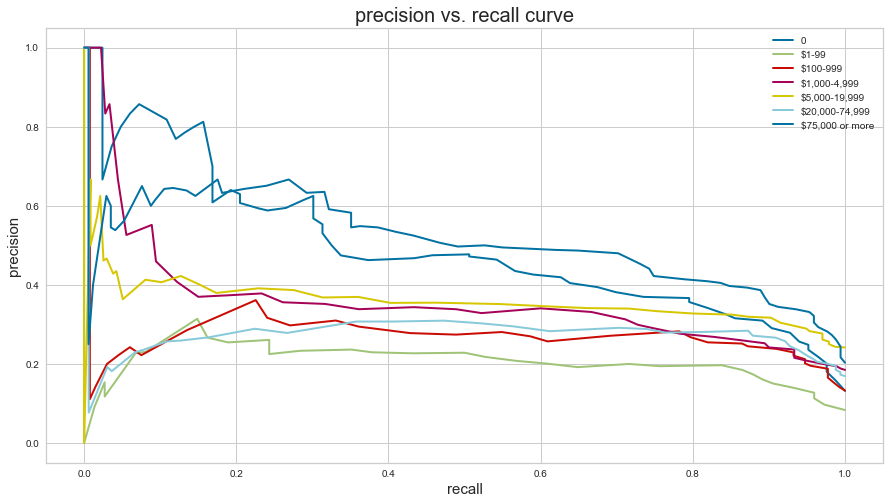

In [47]:
y_pred_full_proba = rf.predict_proba(features_test_all)

Y = label_binarize(target_test_all, classes=[1, 2, 3, 4 ,5, 6, 7])

n_classes = len(set(target_test_all))

# precision recall curve
precision = dict()
recall = dict()
plt.figure(figsize = (15,8))
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y[:, i], y_pred_full_proba[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall", size=15)
plt.ylabel("precision", size=15)
plt.legend(['0','$1-99','$100-999','$1,000-4,999','$5,000-19,999','$20,000-74,999','$75,000 or more'], loc="best")
plt.title("precision vs. recall curve", size=20)
plt.show()

Here we see that the results are more reliable. We can get high precision (to recognize the correct class, but miss many), or recognize the class but have many mistakes.

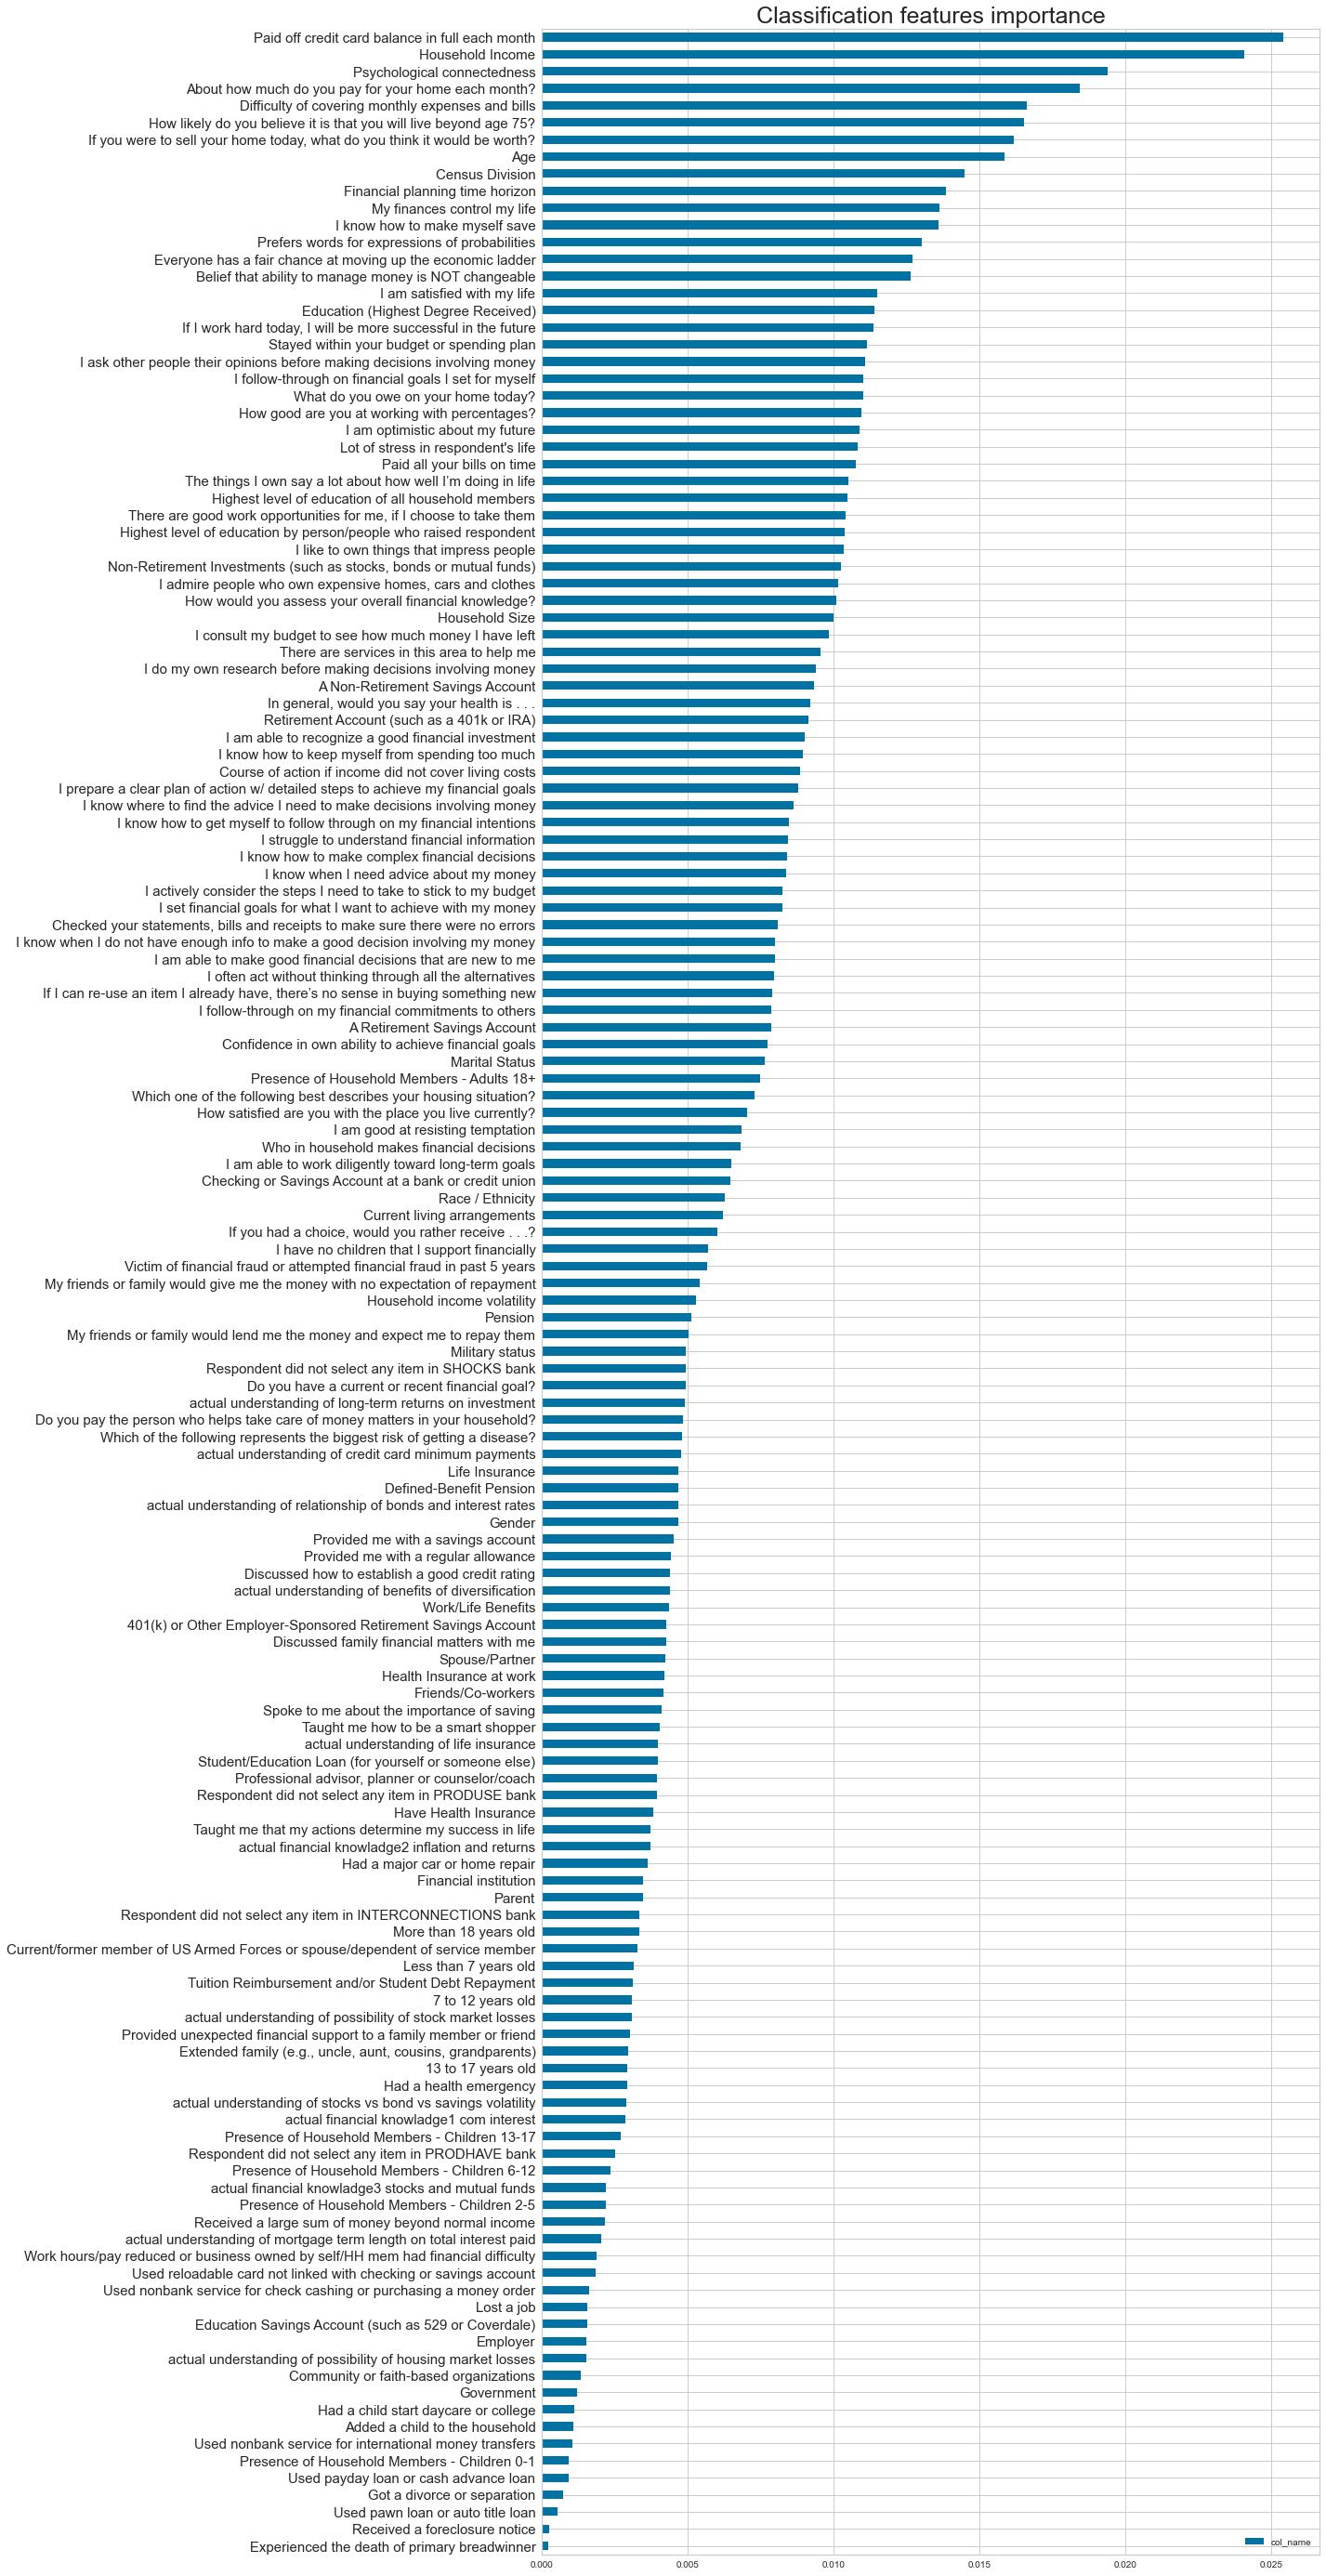

In [48]:
feature_importance_model_full = pd.DataFrame({'col_name': rf.feature_importances_}, index=features_train_all.columns).sort_values(by='col_name', ascending=False)

fig, ax = plt.subplots(figsize =(15, 50))
feature_importance_model_full.sort_values(by='col_name',ascending=True).plot(kind='barh', ax=ax)
plt.title('Classification features importance', size=25)
ax.tick_params(axis='y', labelsize=15)
plt.show()

## Run model on feature with filled values

### Replace unanswered values with NaN

In [49]:
#Replace answers with None values:

#99 Prefer not to say
#98 I don't know
#-1 Refused
#-2 Question not asked because respondent not in item base
#-3 Invalid response
#-4 Response not written to database
#-5 County not known
data_final = data_final.replace([99,98,-1,-2, -3,-4,-5], np.nan)

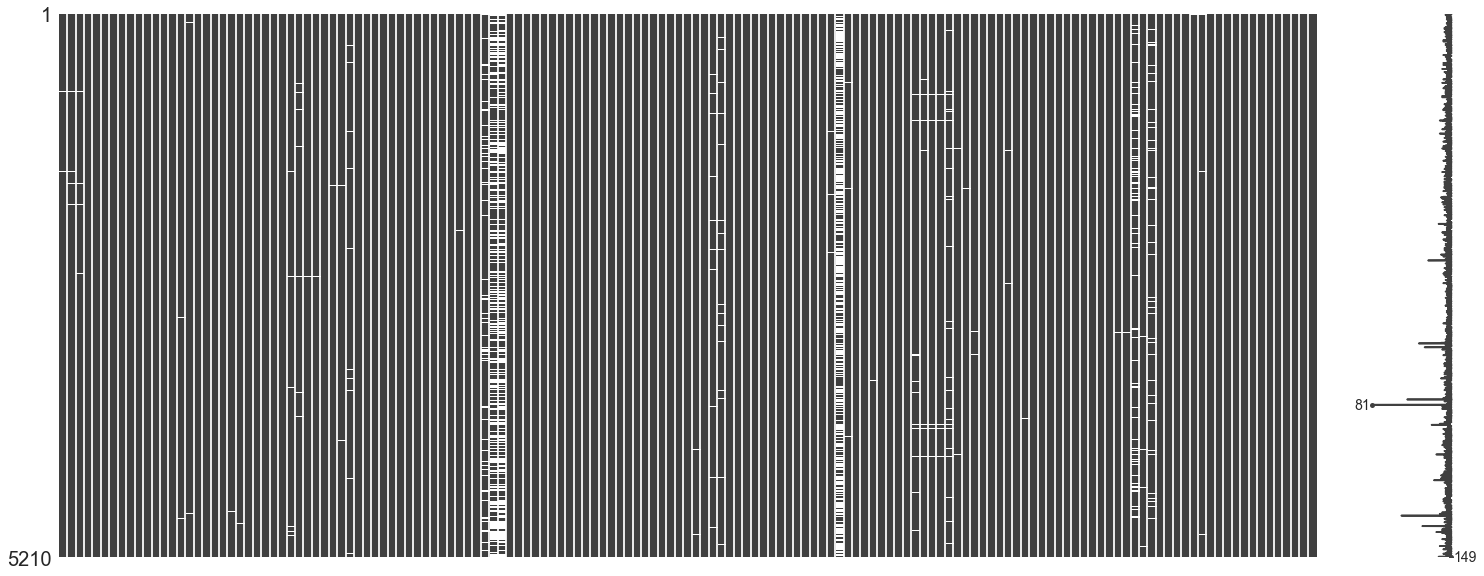

In [50]:
#See missing values
msno.matrix(data_final);

In [51]:
data_final.shape

(5210, 149)

In [52]:
print('We droped',len(original_data) - len(data_final),'observations with unvalid answers')

We droped 1184 observations with unvalid answers


### Check for missing values in the features

In [53]:
#Check for missing values
data_final.stb.missing(style=True)

As we have many missing values and many columns, we will zoom into the main columns to understand how to complete them.

**Missing completely at Random (MCAR):** The probability for missing observation is the same for all.<br><br>
**Missing not at random (MNAR):** The is a reason for the missing values which is related to other observation in the data ot any missing value. <br><br>
**Missing at random (MAR):** there is a reason for the missing data which is related to other missing data.

### consulting

In [54]:
data_upd['Do you pay the person who helps take care of money matters in your household?'].value_counts(normalize=True)

-2    0.517673
 0    0.447764
 1    0.033782
-1    0.000782
Name: Do you pay the person who helps take care of money matters in your household?, dtype: float64

For consulting, we see this question wasn't asked for people who answered that they are the one who are managing their own finances, and not somebody else. This means they are of cource not paying for consulting. We will complete this data with 0: Do you pay the person who helps take care of money matters in your household? No.

In [55]:
#Consulting - fill missing values with 0
data_final['Do you pay the person who helps take care of money matters in your household?'].fillna(0, inplace=True)

### mortgage amount

In [56]:
data_upd['What do you owe on your home today?'].value_counts(normalize=True)

-2     0.348764
 1     0.236472
 2     0.212856
 3     0.097279
 99    0.077886
 98    0.017986
-1     0.008758
Name: What do you owe on your home today?, dtype: float64

For mortgage amount, we see this question wasn't asked for most of the participants when wasn't relevant, but some didn't know or prefered not to asnwer. For these people we will complete the missing value with 1.<br>
What do you owe on your home today? 1. Less than $50,000. because this also means 0, no mortgage.

In [57]:
#Mortgage - fill missing values with 1
data_final['What do you owe on your home today?'].fillna(1, inplace=True)

### home value

In [58]:
data_upd['If you were to sell your home today, what do you think it would be worth?'].value_counts(normalize=True)

-2     0.348764
 2     0.164686
 1     0.161871
 3     0.154989
 4     0.125743
 99    0.024867
 98    0.017986
-1     0.001095
Name: If you were to sell your home today, what do you think it would be worth?, dtype: float64

For home value, we see this question wasn't asked for most of the participants when wasn't relevant, but some didn't know or prefered not to asnwer. <br>
For this question we will use the imputer as the value of the house people live in, regardless of owning the house, will indicate about their financial capabilities.

## Check correlations

In [59]:
data_final.shape

(5210, 149)

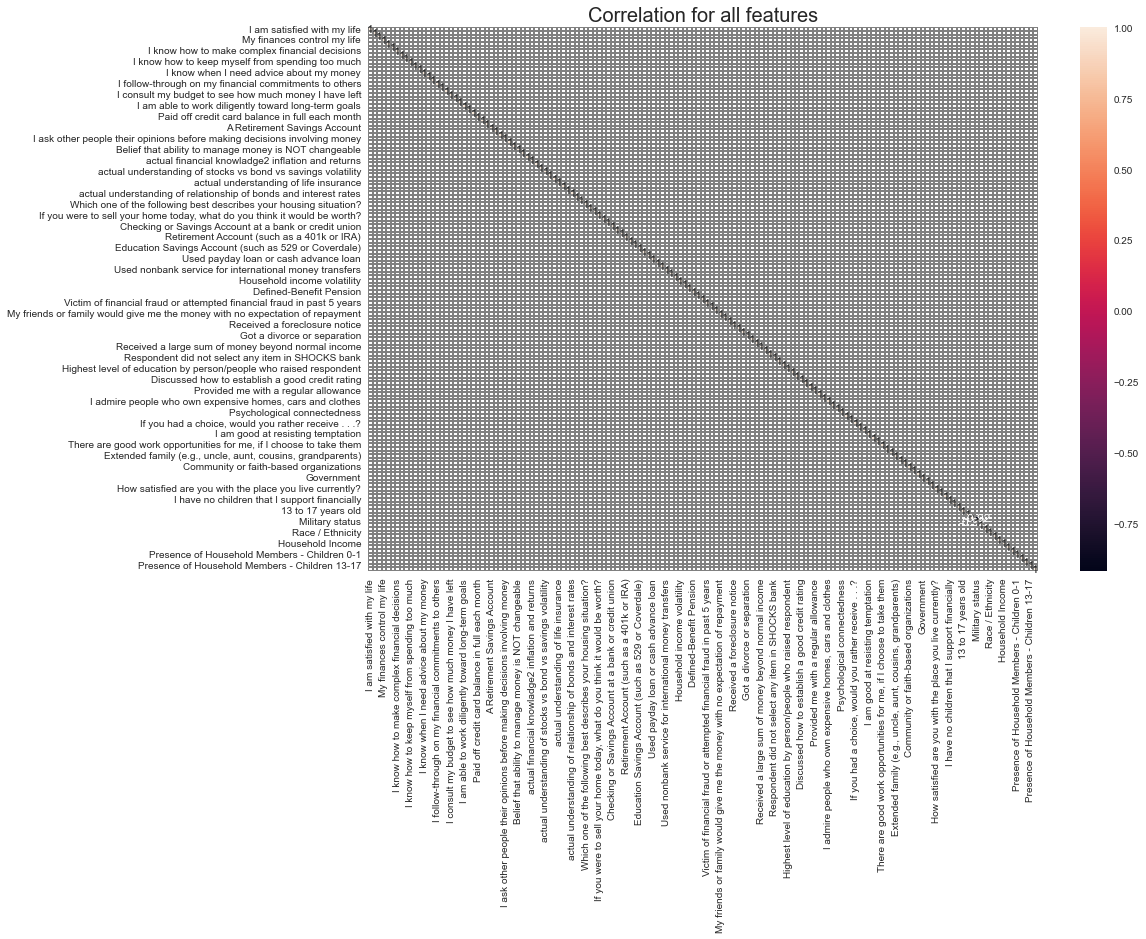

In [60]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(data_final.corr()[(data_final.corr()>0.9) | (data_final.corr()<-0.9)], ax=ax, 
            linewidths=.01,linecolor='gray',annot=True)
plt.title('Correlation for all features', size=20)
plt.show()

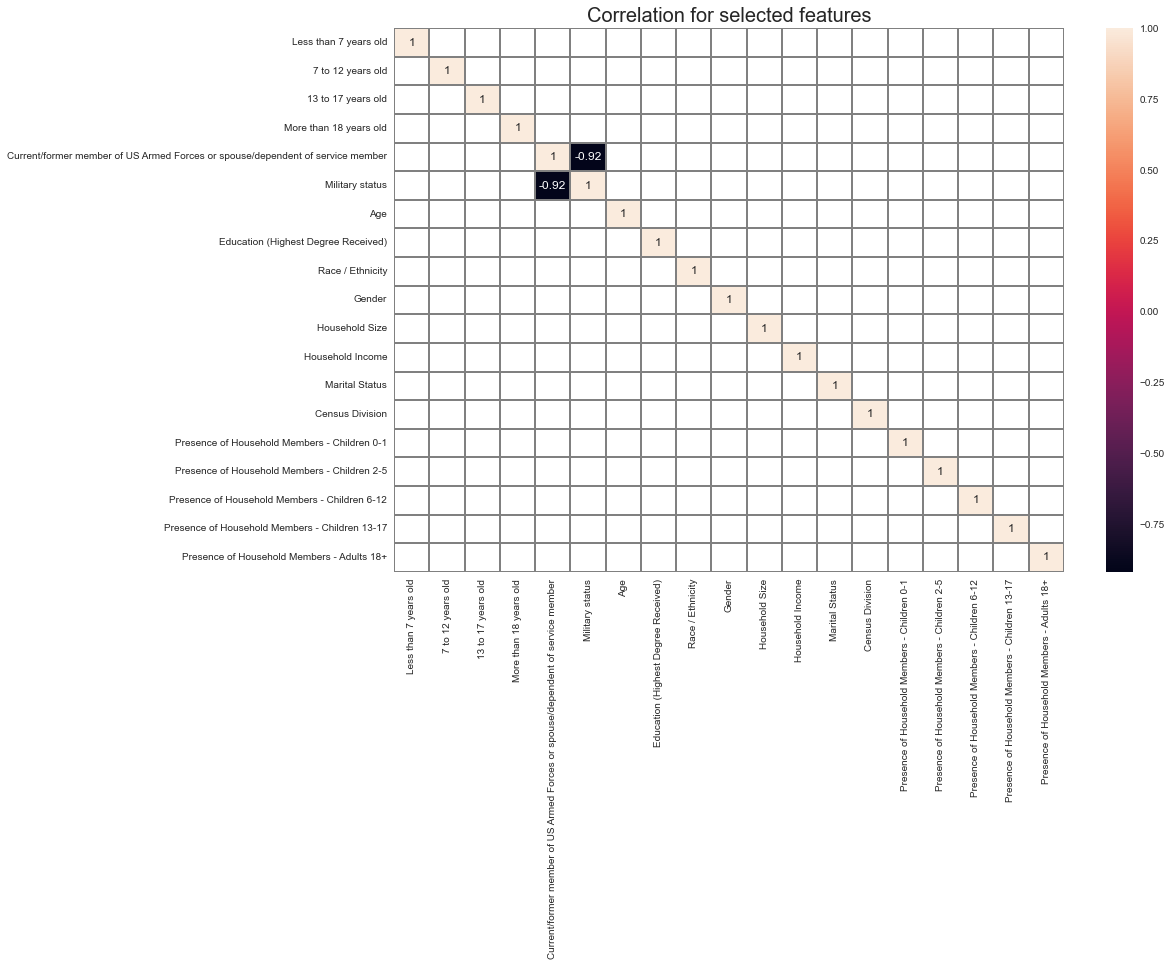

In [61]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(data_final[data_final.columns[130:162]].corr()[(data_final[data_final.columns[130:162]].corr()>0.9) | (data_final[data_final.columns[130:162]].corr()<-0.9)], ax=ax, 
            linewidths=.01,linecolor='gray',annot=True)
plt.title('Correlation for selected features', size=20)
plt.show()

We see high correlation between:<br>
1. Military status and Current/former member of US Armed Forces or spouse/dependent of service member: 92%. Military Feature is constructed using Current/former member of US Armed Forces or spouse/dependent of service member and age. We will keep them both.

## Split the data

We will split the data into train (80%) and test (20%) sets and run cross validation on the train set.

In [62]:
target = data_final['target']
features = data_final.drop(['target'], axis=1)

#split into 80% (will be used with cross validation) train and 20% test
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

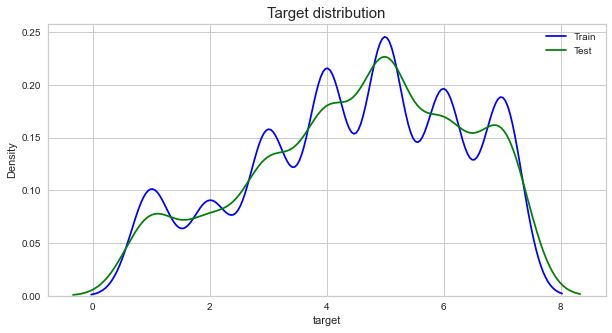

In [63]:
#See target distribution between groups

fig, axs = plt.subplots(figsize=(10, 5))
sns.kdeplot(data=target_train, ax=axs, color='blue', label='Train')
sns.kdeplot(data=target_test, ax=axs, color='green', label='Test')
plt.title('Target distribution', size=15)
plt.legend()
plt.show()

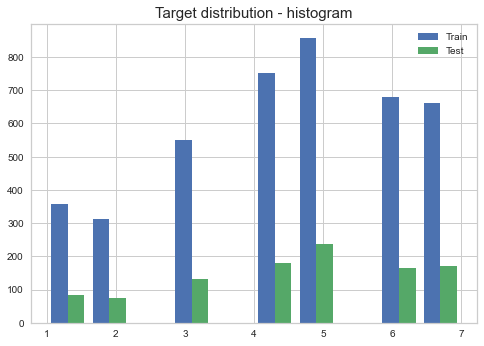

In [64]:
plt.style.use('seaborn-deep')
plt.hist([target_train, target_test], label=['Train', 'Test'])
plt.legend(loc='upper right')
plt.title('Target distribution - histogram', size=15)
plt.show()

Our data is not balanced - we will upsample it later.

In [65]:
#Remove all spaces and signs in the column names to be able process the data
features_train_full = features_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))

In [66]:
features_train_full.head()

I_am_satisfied_with_my_life  I_am_optimistic_about_my_future  \
5085                          7.0                              7.0   
1080                          5.0                              5.0   
3873                          6.0                              6.0   
55                            6.0                              6.0   
2057                          6.0                              6.0   

      If_I_work_hard_today_I_will_be_more_successful_in_the_future  \
5085                                                7.0              
1080                                                5.0              
3873                                                6.0              
55                                                  6.0              
2057                                                6.0              

      My_finances_control_my_life  \
5085                          3.0   
1080                          4.0   
3873                          3.0   
55                            3.0   
2057                          2.0   

      I_know_how_to_get_myself_to_follow_through_on_my_financial_intentions  \
5085                                                4.0                       
1080                                                3.0                       
3873                                                4.0                       
55                                                  4.0                       
2057                                                3.0                       

      I_know_where_to_find_the_advice_I_need_to_make_decisions_involving_money  \
5085                                                4.0                          
1080                                                4.0                          
3873                                                4.0                          
55                                                  4.0                          
2057                                                4.0                          

      I_know_how_to_make_complex_financial_decisions  \
5085                                             4.0   
1080                                             4.0   
3873                                             4.0   
55                                               4.0   
2057                                             3.0   

      I_am_able_to_make_good_financial_decisions_that_are_new_to_me  \
5085                                                4.0               
1080                                                4.0               
3873                                                4.0               
55                                                  3.0               
2057                                                4.0               

      I_am_able_to_recognize_a_good_financial_investment  \
5085                                                4.0    
1080                                                4.0    
3873                                                4.0    
55                                                  3.0    
2057                                                3.0    

      I_know_how_to_keep_myself_from_spending_too_much  ...  Gender  \
5085                                               4.0  ...     1.0   
1080                                               4.0  ...     1.0   
3873                                               4.0  ...     2.0   
55                                                 4.0  ...     2.0   
2057                                               4.0  ...     1.0   

      Household_Size  Household_Income  Marital_Status  Census_Division  \
5085             5.0               7.0             1.0              8.0   
1080             5.0               7.0             3.0              9.0   
3873             4.0               8.0             1.0              3.0   
55               1.0               5.0             4.0              3.0   
2057             3.0               9.0        

### Fill missing values using MICE - Multiple Imputation by Chained Equation

Link to this explanation: https://stats.stackexchange.com/questions/421545/multiple-imputation-by-chained-equations-mice-explained#:~:text=MICE%20is%20a%20multiple%20imputation,are%20missing%20completely%20at%20random).

"Step 1: Replace (or impute) the missing values in each variable with temporary "place holder" values derived solely from the non-missing values available for that variable. For example, replace the missing age value with the mean age value observed in the data, replace the missing income values with the mean income value observed in the data, etc.

Step 2 Set back to missing the “place holder” imputations for the age variable only. This way, the current data copy contains missing values for age, but not for income and gender.

Step 3: Regress age on income and gender via a linear regression model (though it is possible to also regress age on only one of these variables); to be able to fit the model to the current data copy, drop all the records where age is missing during the model fitting process. In this model, age is the dependent variable and income and gender are the independent variables.

Step 4 Use the fitted regression model in the previous step to predict the missing age values. (When age will be subsequently used as an independent variable in the regression models for other variables, both the observed values of age and these predicted values will be used.) The article doesn't make it clear that a random component should be added to these predictions.

Step 5: Repeat Steps 2–4 separately for each variable that has missing data, namely income and gender."

We assume that the data is missing at random - there is some relationship with other observations.

In [67]:
kernel = mf.ImputationKernel(
  features_train_full,
  datasets=4,
  save_all_iterations=True,
  random_state=42
)

In [68]:
%%time
# Run the MICE algorithm for 3 iterations on each of the datasets
kernel.mice(3,verbose=False)

Wall time: 6min 31s


In [69]:
features_train_full_mice = kernel.complete_data(dataset=0, inplace=False)

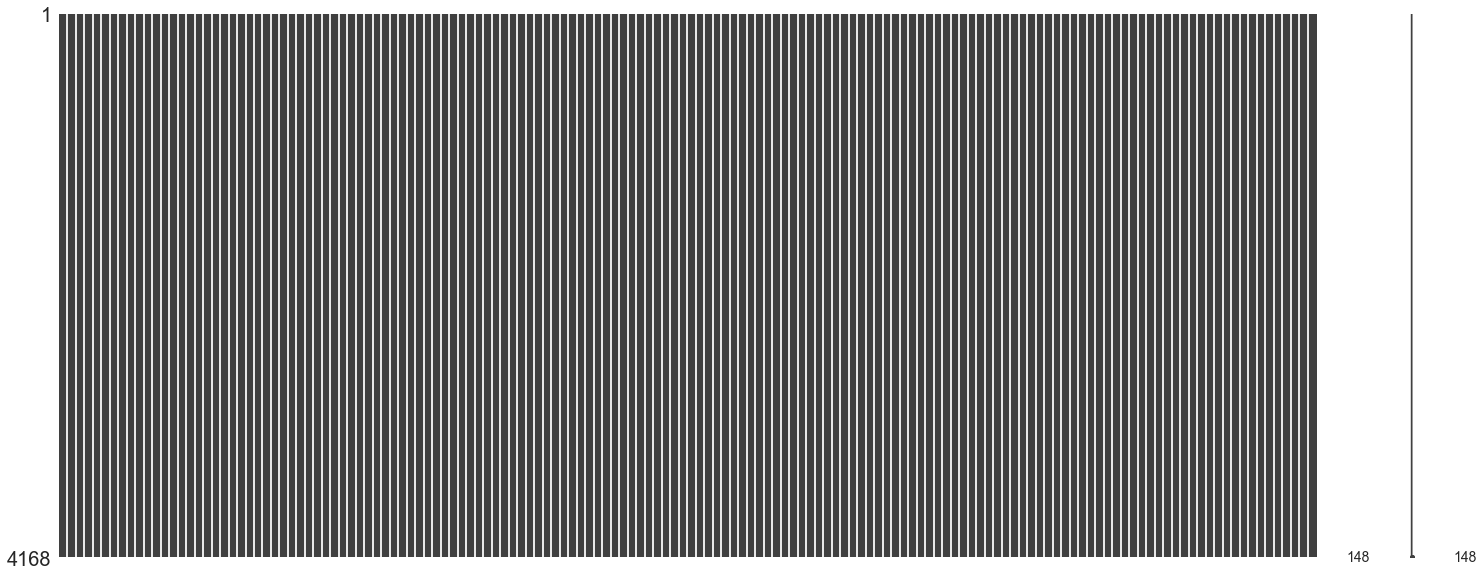

In [70]:
msno.matrix(features_train_full_mice);

In [71]:
model = RandomForestClassifier(random_state=42)
model.fit(features_train_full_mice, target_train)

RandomForestClassifier(random_state=42)

In [72]:
features_test_full = features_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))

In [73]:
kernel_test = mf.ImputationKernel(
  features_test_full,
  datasets=4,
  save_all_iterations=True,
  random_state=42
)
features_test_full_mice = kernel_test.complete_data(dataset=0, inplace=False)

In [74]:
%%time
# Run the MICE algorithm for 3 iterations on each of the datasets
kernel_test.mice(3,verbose=False)

Wall time: 2min 20s


In [75]:
y_pred = model.predict(features_test_full_mice)

In [76]:
print(classification_report(target_test, y_pred, target_names=['0','$1-99','$100-999','$1,000-4,999',
                                                               '$5,000-19,999','$20,000-74,999','$75,000 or more']))

                 precision    recall  f1-score   support

              0       0.46      0.55      0.50        83
          $1-99       0.42      0.11      0.17        74
       $100-999       0.40      0.38      0.39       133
   $1,000-4,999       0.37      0.44      0.40       180
  $5,000-19,999       0.38      0.42      0.40       236
 $20,000-74,999       0.33      0.25      0.29       165
$75,000 or more       0.49      0.53      0.51       171

       accuracy                           0.40      1042
      macro avg       0.40      0.38      0.38      1042
   weighted avg       0.40      0.40      0.39      1042



We see small increase in f1-score macro avg and f1-score weighted avg compared to original values (0.36 amd 0.37)

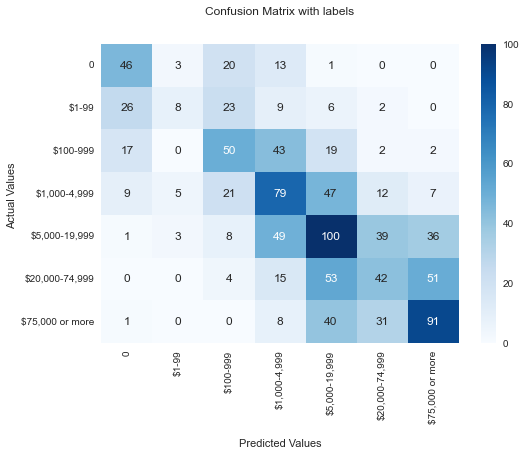

In [77]:
#confusion_matrix
conf= confusion_matrix(target_test, y_pred)

ax = sns.heatmap(conf, annot=True, cmap='Blues',fmt='g')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.set_xticklabels(['0','$1-99','$100-999','$1,000-4,999','$5,000-19,999','$20,000-74,999','$75,000 or more'])
ax.set_yticklabels(['0','$1-99','$100-999','$1,000-4,999','$5,000-19,999','$20,000-74,999','$75,000 or more'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

It would be interstin to exemine why the model predicted saving of 0 to someone who has USD75,000 or more.

In [78]:
test_pred = pd.DataFrame({'target_test': target_test, 'y_pred':y_pred}, index=target_test.index)

In [79]:
test_pred[(test_pred['target_test']==7) & (test_pred['y_pred']==1)]

target_test  y_pred
3573          7.0     1.0

Participant number 3573

In [80]:
features_test_full_mice.loc[3573]

I_am_satisfied_with_my_life                                              7.0
I_am_optimistic_about_my_future                                          7.0
If_I_work_hard_today_I_will_be_more_successful_in_the_future             7.0
My_finances_control_my_life                                              3.0
I_know_how_to_get_myself_to_follow_through_on_my_financial_intentions    3.0
                                                                        ... 
Presence_of_Household_Members_Children_0_1                               0.0
Presence_of_Household_Members_Children_2_5                               0.0
Presence_of_Household_Members_Children_6_12                              0.0
Presence_of_Household_Members_Children_13_17                             0.0
Presence_of_Household_Members_Adults_18_                                 2.0
Name: 3573, Length: 148, dtype: float64

### ROC curve

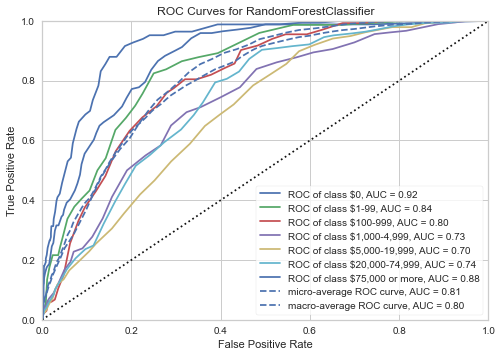

In [81]:
#In random forest, the tresholds are fraction of trees voting for the correct answer
visual = plot_ROC_curve(model, features_train_full_mice, target_train, features_test_full_mice, target_test)

### PR curve

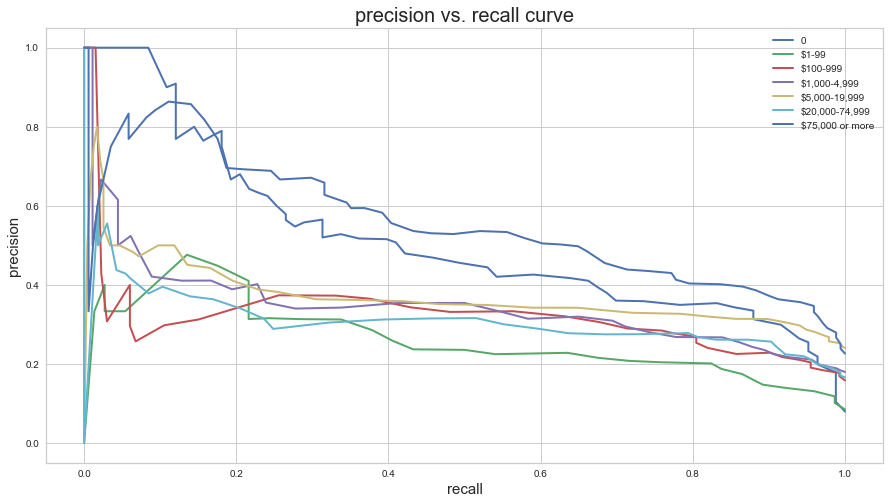

In [82]:
pr_curve(model, features_test_full_mice, target_test)

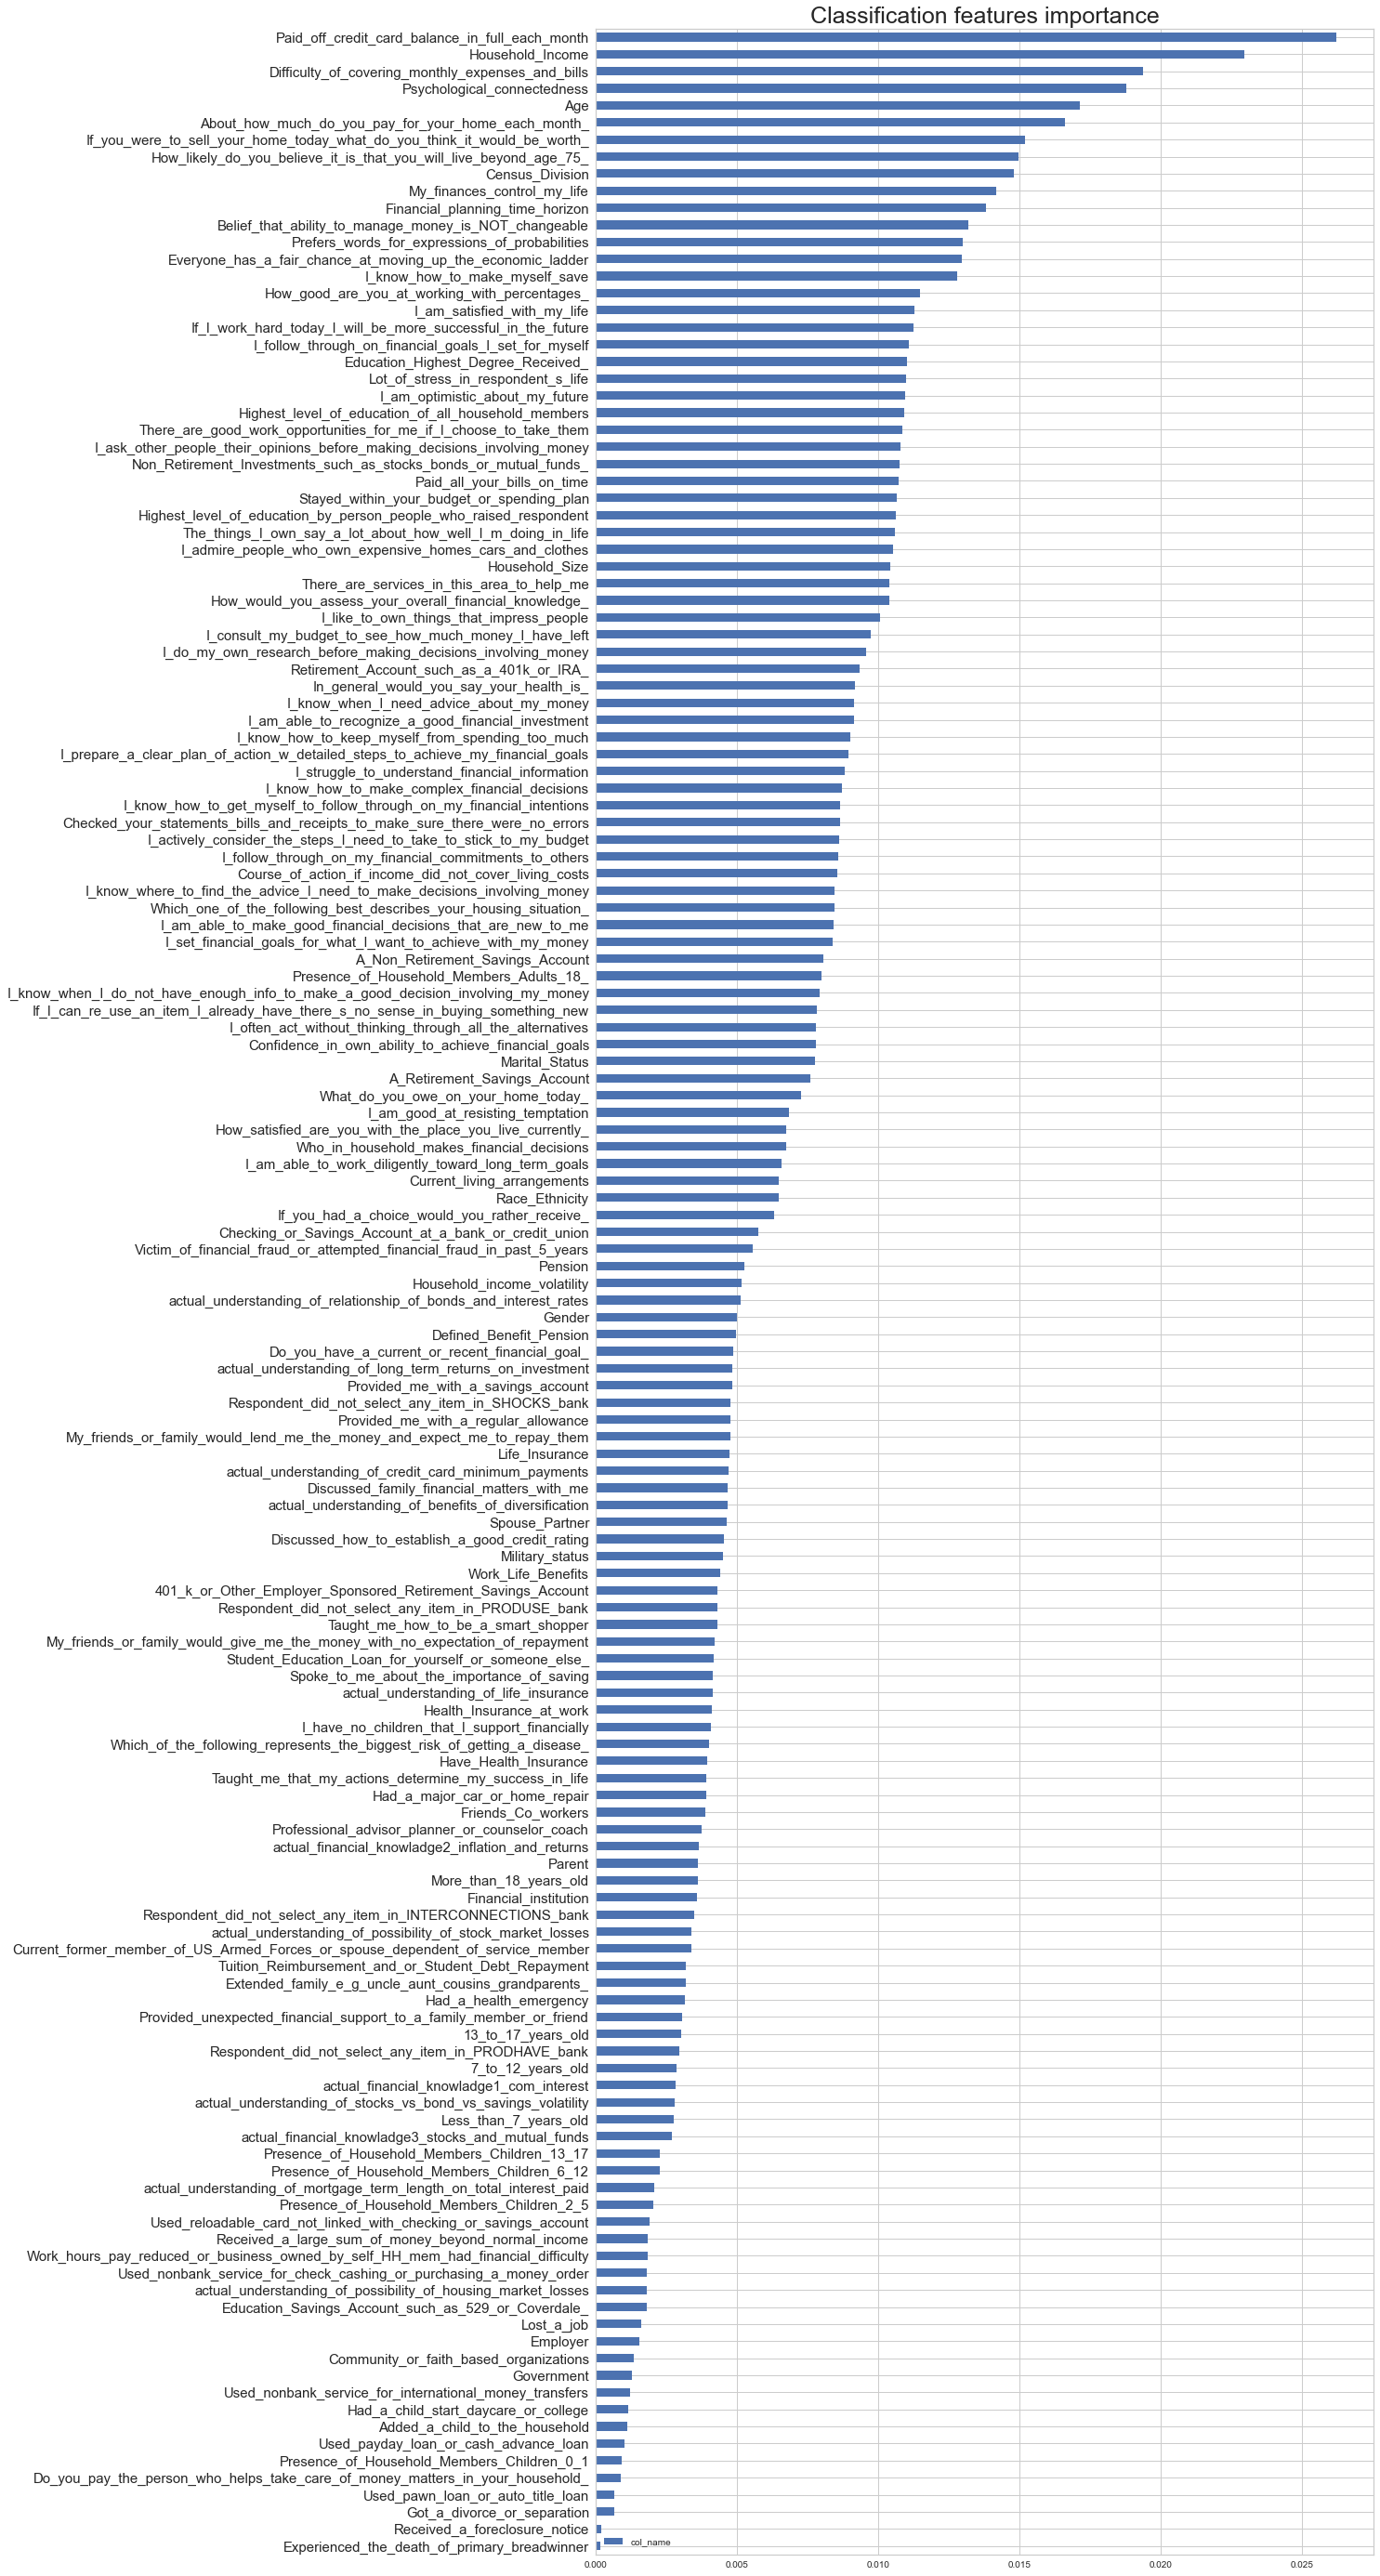

In [83]:
feature_importance_model = pd.DataFrame({'col_name': model.feature_importances_}, index=features_train_full_mice.columns).sort_values(by='col_name', ascending=False)

fig, ax = plt.subplots(figsize =(15, 50))
feature_importance_model.sort_values(by='col_name',ascending=True).plot(kind='barh', ax=ax)
plt.title('Classification features importance', size=25)
ax.tick_params(axis='y', labelsize=15)
plt.show()

In [84]:
%%time
#See explanation for test set
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(features_test_full_mice)

Wall time: 5min 45s


In [85]:
classes={1: '$0',
2: '$1-99', 
3: '$100-999',
4: '$1,000-4,999',
5: '$5,000-19,999',
6: '$20,000-74,999',
7: '$75,000 or more'}

Class: $0


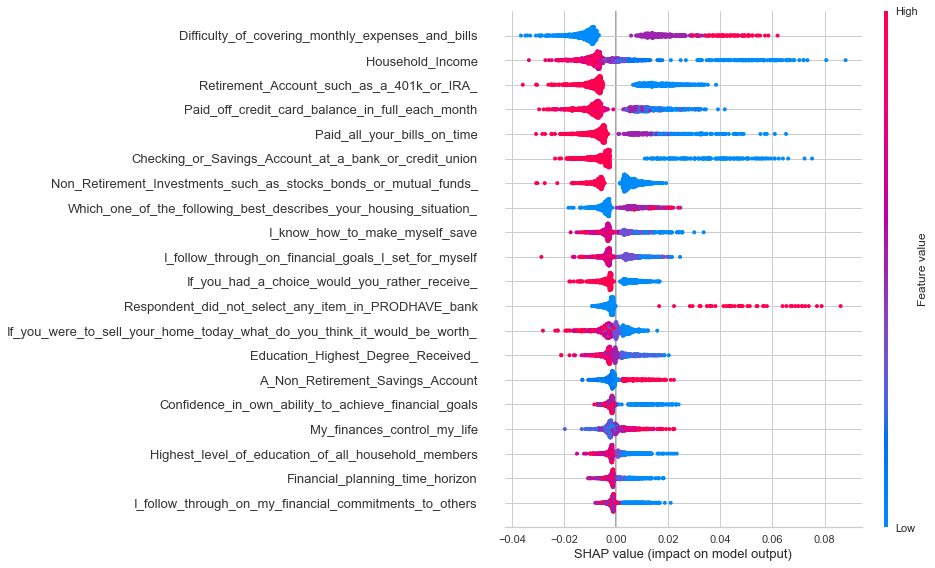

Class: $1-99


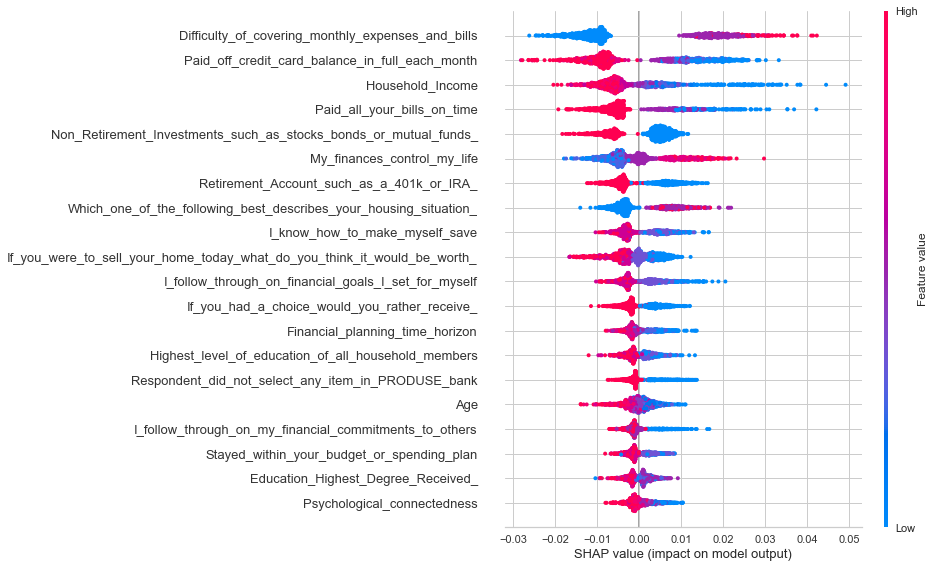

Class: $100-999


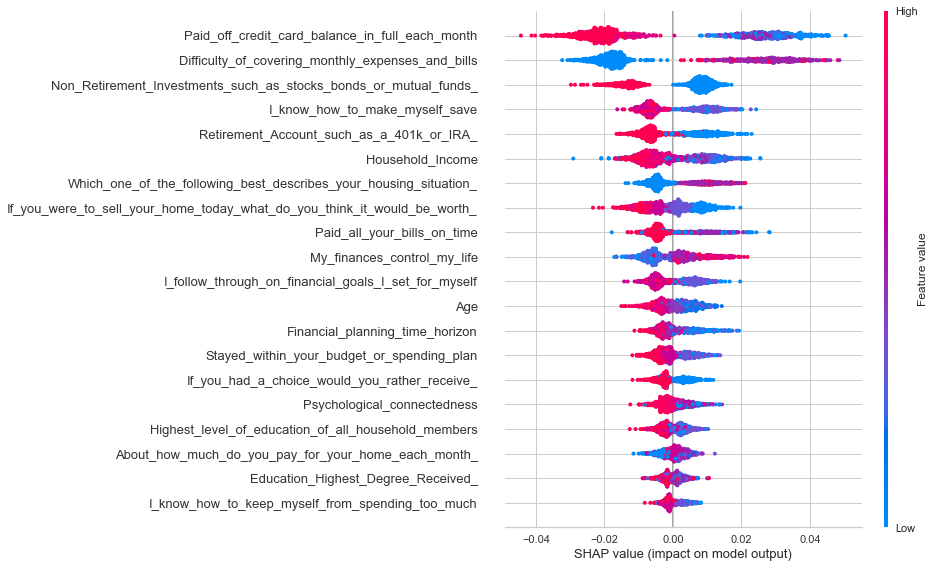

Class: $1,000-4,999


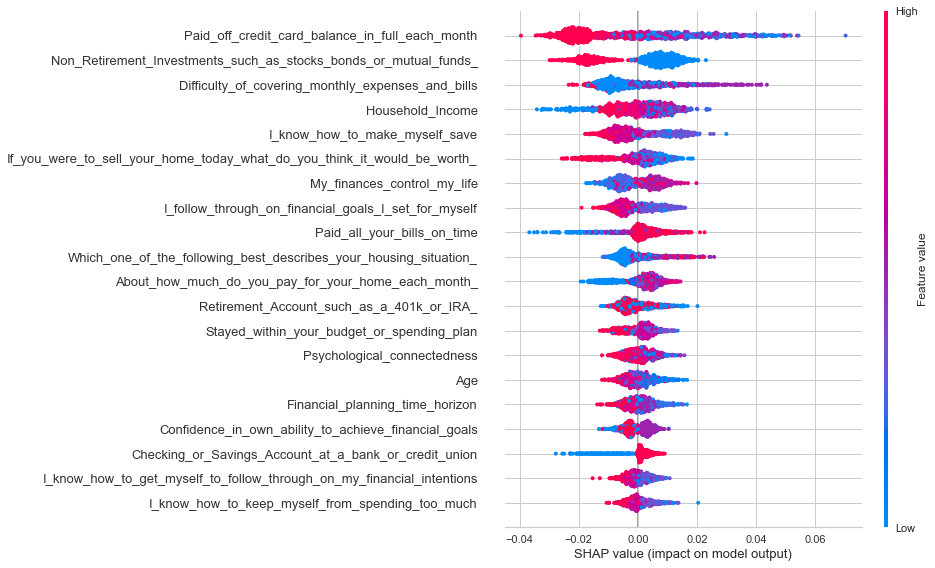

Class: $5,000-19,999


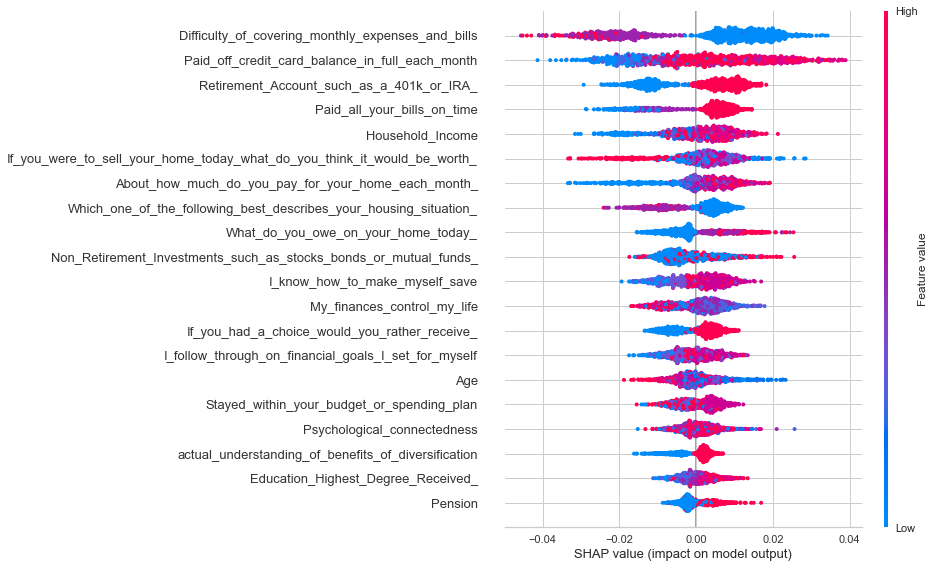

Class: $20,000-74,999


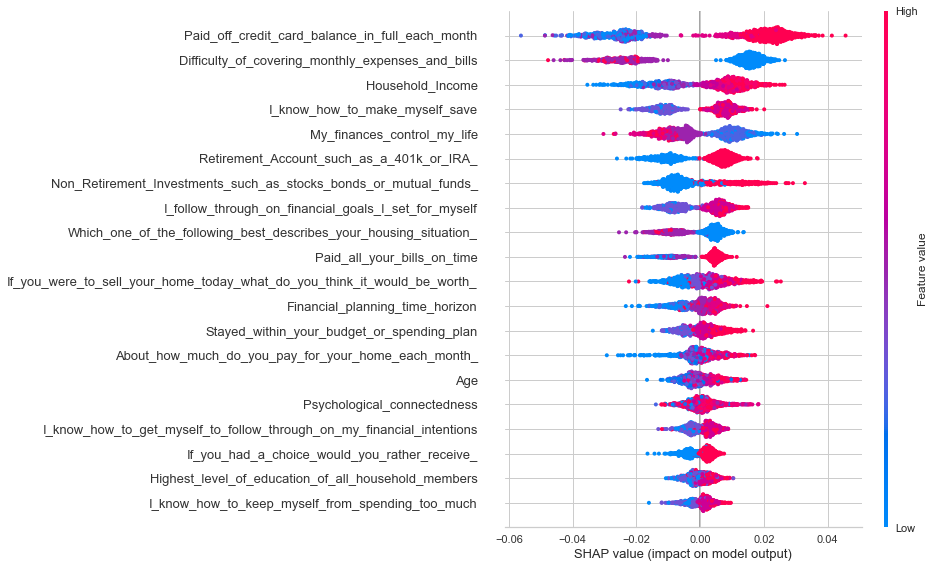

Class: $75,000 or more


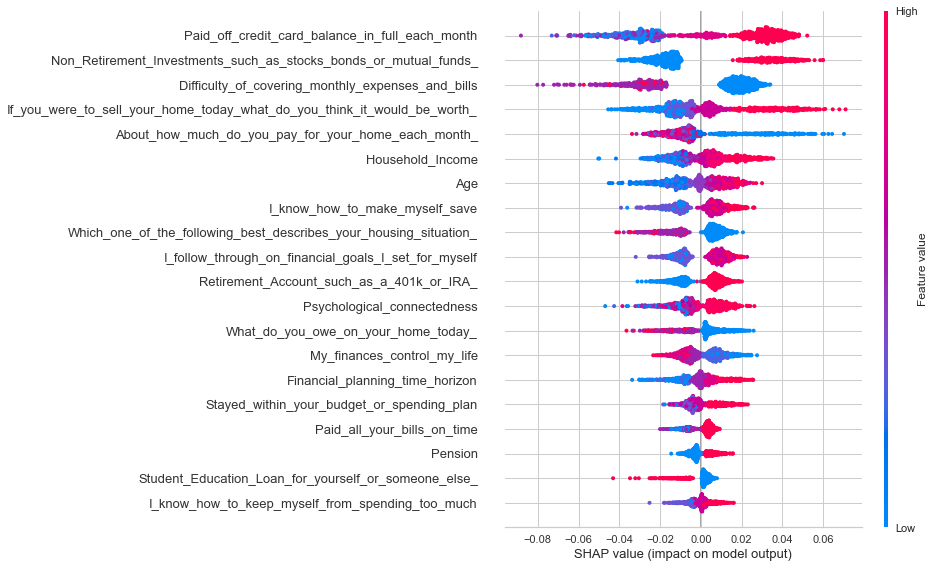

In [86]:
for i in range(1,8):
    print('Class:', classes[i])
    shap.summary_plot(shap_values[i-1], features_test_full_mice.values, feature_names = features_test_full_mice.columns)

Here we can interstingly see the differences between USD 0 preidction and USD 75K and more predictions. For example where high values of purchase managemnet increasing the probability for class USD 0, while decraseing the probabiltiy for class USD 75K and more.

### Exemine why the model predicted saving of USD 100 - 999 to someone who has USD 75,000 or more.

In [87]:
test_pred[(test_pred['target_test']==7) & (test_pred['y_pred']==1)]

target_test  y_pred
3573          7.0     1.0

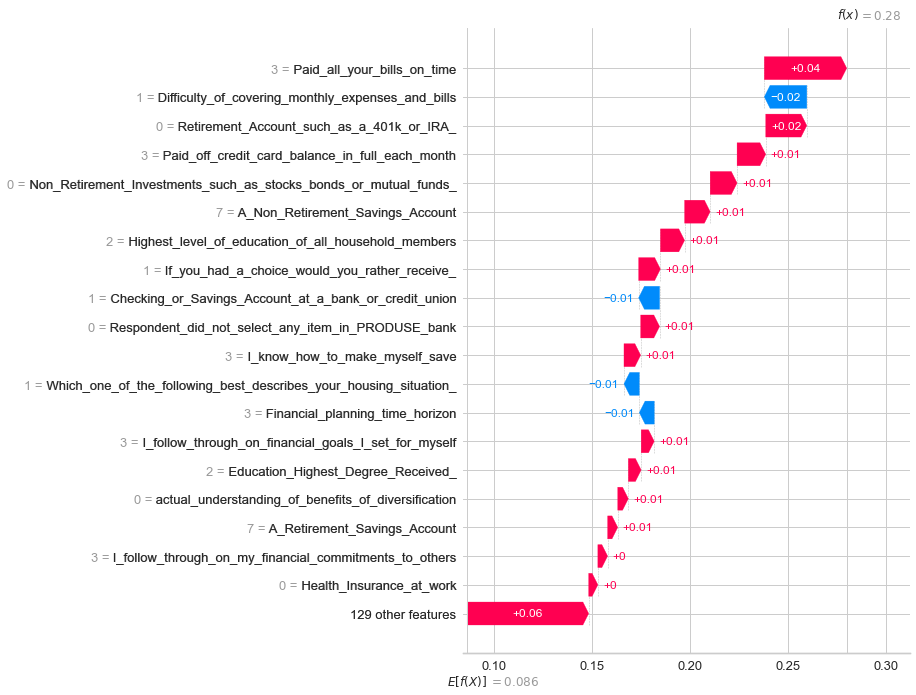

In [88]:
#See specific obseration
#Class as defined in the target
class_to_exemine = 1
#Original observation in the set
observ = 3573

#Class starting from 0
saving_class = class_to_exemine-1

#Observation ordinal number
row_shape = len(features_test_full_mice.loc[:observ])-1

shap.waterfall_plot(shap.Explanation(values=shap_values[saving_class][row_shape], 
           base_values=explainer.expected_value[saving_class], data=features_test_full_mice.loc[observ],  
                                         feature_names=features_test_full_mice.columns.tolist()),max_display=20)

**Observation 2721**

For a specific class: 1<br>
Observation: 2721 <br>
E[f(x)] is the base value - average probability of class 1 regardless of the features.<br>
f(x) is the model predicted probabiltiy to this class for the specific observation.

The main reason participant 2721 was classified into USD 0, while had USD 75K or more was because he answered: He has no checking or saving account, Difficulty of covering monthly expenses and bills - Somewhat difficult (2), I know how to make myself save - Very little (2), no retirment account.

In the other hand, he answered: Paid off credit card balance in full each month - always (5), Income USD 150,000 or more.

**Observation 3573**

For a specific class: 1<br>
Observation: 3573 <br>
E[f(x)] is the base value - average probability of class 1 regardless of the features.<br>
f(x) is the model predicted probabiltiy to this class for the specific observation.

Paid all bills on time - sometimes (3), no retirment account, paid credit card in full - simetimes (3), no stocks or bonds, don't have A Non-Retirement Savings Account. On the other hand, have no problem covering monthly expenses.

<!-- **Observation 3573**

The main reason participant 3573 was classified into USD 100 - 999 was because he answered: Paid off credit card balance in full each month - sometimes (3), he has no retirement account (0), income between  USD 40K to 49.9K (4), I know how to make myself save - somewhat (3), My finances control my life - sometimes(3), no bonds or stocks, Highest level of education of all household members - High school degree/GED (2). -->

# Models

After the initial exemination we observed that replacing unwanted values has minor affect on the metrics. We will use the new values and fit a pipeline wuth upsample and GridSearchCV.

**f1_macro** - the metrics treats all classes equally regardless of their support values. Each class f1 divided by number of classes. <br>
**f1_weighted** - Using each f1 score and multiplying each class’s proportion of observations.

### GridSearchCV

We will use the grid function we created above - best_model.

In [89]:
#Create empty tuple for score
models_score = {}

## Pipeline

We will use pipeline to do upsample with cross validation. Standardize the data fir SVM which uses distances, because some of the features have values between 1-100, and run the model with different hyperparameters.

### Logistic regression - initial data

In [90]:
pipe = Pipeline([('over',RandomOverSampler(random_state=12345)), ('model',LogisticRegression())])

log_reg_initial = best_model(pipe, {}, features_train_all, target_train_all)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..............., score=(train=0.404, test=0.334) total time=   0.6s
[CV 2/5] END ..............., score=(train=0.392, test=0.327) total time=   0.7s
[CV 3/5] END ..............., score=(train=0.395, test=0.314) total time=   0.8s
[CV 4/5] END ..............., score=(train=0.401, test=0.345) total time=   0.6s
[CV 5/5] END ..............., score=(train=0.400, test=0.354) total time=   0.6s

Best parameters: {}

Best score: 0.33


In [92]:
y_pred_lr_initial = log_reg_initial.predict(features_test_all)

In [93]:
print(classification_report(target_test_all, y_pred_lr_initial, target_names=['0','$1-99','$100-999','$1,000-4,999',
                                                               '$5,000-19,999','$20,000-74,999','$75,000 or more']))

                 precision    recall  f1-score   support

              0       0.40      0.61      0.48        83
          $1-99       0.19      0.24      0.22        74
       $100-999       0.29      0.24      0.26       133
   $1,000-4,999       0.35      0.31      0.33       180
  $5,000-19,999       0.37      0.22      0.28       236
 $20,000-74,999       0.30      0.31      0.31       165
$75,000 or more       0.43      0.60      0.50       171

       accuracy                           0.35      1042
      macro avg       0.33      0.36      0.34      1042
   weighted avg       0.34      0.35      0.34      1042



### Logistic regression - imputed values

In [94]:
features_train_full_mice.shape

(4168, 148)

As we have 148 categorical features, we are not encoding them into dummy variables for logistic regression. This will cause the model to think that the values are categorical ro numerical, in some sense they are.

In [95]:
pipe = Pipeline([('over',RandomOverSampler(random_state=12345)), ('model',LogisticRegression())])

log_reg = best_model(pipe, {}, features_train_full_mice, target_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..............., score=(train=0.402, test=0.335) total time=   0.5s
[CV 2/5] END ..............., score=(train=0.396, test=0.354) total time=   0.4s
[CV 3/5] END ..............., score=(train=0.406, test=0.334) total time=   0.4s
[CV 4/5] END ..............., score=(train=0.388, test=0.349) total time=   0.4s
[CV 5/5] END ..............., score=(train=0.399, test=0.326) total time=   0.4s

Best parameters: {}

Best score: 0.34


In [96]:
y_pred_lr = log_reg.predict(features_test_full_mice)


In [97]:
print(classification_report(target_test, y_pred_lr, target_names=['0','$1-99','$100-999','$1,000-4,999',
                                                               '$5,000-19,999','$20,000-74,999','$75,000 or more']))

                 precision    recall  f1-score   support

              0       0.42      0.59      0.49        83
          $1-99       0.23      0.30      0.26        74
       $100-999       0.30      0.29      0.30       133
   $1,000-4,999       0.37      0.32      0.35       180
  $5,000-19,999       0.43      0.25      0.31       236
 $20,000-74,999       0.32      0.38      0.34       165
$75,000 or more       0.48      0.60      0.53       171

       accuracy                           0.37      1042
      macro avg       0.36      0.39      0.37      1042
   weighted avg       0.38      0.37      0.37      1042



In [98]:
#Save test, validation and test f1 weighted scores:
models_score['Logisitc Regression'] = [round(log_reg.cv_results_['mean_train_score'].mean(),2),
                                       round(log_reg.cv_results_['mean_test_score'].mean(),2),
                                       round(f1_score(target_test, y_pred_lr, average='weighted'),2)]

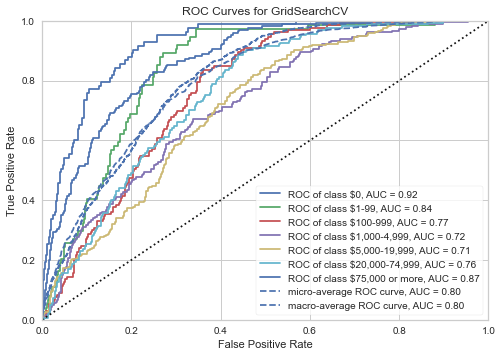

In [99]:
visual = plot_ROC_curve(log_reg, features_train_full_mice, target_train, features_test_full_mice, target_test)

### Best tresholds - logistic regression - only for binary

In [100]:
# from sklearn.metrics import roc_curve
# fpr, tpr, thresholds = roc_curve(target_test, y_pred_lr)

# # calculate the geometric mean for each threshold
# gmeans = np.sqrt(tpr * (1-fpr))

# # locate the index of the largest g-mean
# ix = argmax(gmeans)

# print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

### SVM

In [101]:
%%time

# C - Regularization parameter. The strength of the regularization is inversely proportional to C. 
# Must be strictly positive. The penalty is a squared l2 penalty.

# gamma - The gamma parameters can be seen as the inverse of the radius of influence of 
# samples selected by the model as support vectors. When gamma is very small, the model is too constrained and cannot capture 
# the complexity or “shape” of the data. 
pipe = Pipeline([('over',RandomOverSampler(random_state=12345)), ('scaler',StandardScaler()),('model',SVC())])

param_grid = {'model__C': [0.1, 1000],
              'model__gamma': [1,  0.01],
              'model__kernel': ['rbf','sigmoid'], 'model__probability':[True]}

svc = best_model(pipe, param_grid, features_train_full_mice, target_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END model__C=0.1, model__gamma=1, model__kernel=rbf, model__probability=True;, score=(train=0.531, test=0.071) total time=  20.8s
[CV 2/5] END model__C=0.1, model__gamma=1, model__kernel=rbf, model__probability=True;, score=(train=0.534, test=0.071) total time=  23.6s
[CV 3/5] END model__C=0.1, model__gamma=1, model__kernel=rbf, model__probability=True;, score=(train=0.536, test=0.070) total time=  22.5s
[CV 4/5] END model__C=0.1, model__gamma=1, model__kernel=rbf, model__probability=True;, score=(train=0.534, test=0.070) total time=  23.1s
[CV 5/5] END model__C=0.1, model__gamma=1, model__kernel=rbf, model__probability=True;, score=(train=0.534, test=0.070) total time=  21.6s
[CV 1/5] END model__C=0.1, model__gamma=1, model__kernel=sigmoid, model__probability=True;, score=(train=0.154, test=0.165) total time=  10.1s
[CV 2/5] END model__C=0.1, model__gamma=1, model__kernel=sigmoid, model__probability=True;, score=(tra

In [102]:
y_pred_svc = svc.predict(features_test_full_mice)

In [103]:
print(classification_report(target_test, y_pred_svc, target_names=['0','$1-99','$100-999','$1,000-4,999',
                                                               '$5,000-19,999','$20,000-74,999','$75,000 or more']))

                 precision    recall  f1-score   support

              0       0.41      0.57      0.47        83
          $1-99       0.23      0.12      0.16        74
       $100-999       0.33      0.30      0.31       133
   $1,000-4,999       0.34      0.38      0.36       180
  $5,000-19,999       0.37      0.36      0.37       236
 $20,000-74,999       0.34      0.32      0.33       165
$75,000 or more       0.50      0.53      0.51       171

       accuracy                           0.38      1042
      macro avg       0.36      0.37      0.36      1042
   weighted avg       0.37      0.38      0.37      1042



In [104]:
#Save test, validation and test f1 weighted scores:
models_score['SVC'] = [round(svc.cv_results_['mean_train_score'].mean(),2),
                       round(svc.cv_results_['mean_test_score'].mean(),2),
                        round(f1_score(target_test, y_pred_svc, average='weighted'),2)]

### Decision Tree

In [105]:
%%time
# max_depth - The maximum depth of the tree. Need to restriced to avoid overfitting
# min_samples_split - minimum samples required to split internal node
# min_samples_leaf - The minimum number of samples required to be at a leaf node
pipe = Pipeline([('over',RandomOverSampler(random_state=12345)), ('model',DecisionTreeClassifier(random_state=12345))])

dt = best_model(pipe, {'model__max_depth' : [10,20],
                      'model__min_samples_split': [1,10,20],
                      'model__min_samples_leaf': [1,5,10]}, features_train_full_mice, target_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=1;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=1;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=1;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=1;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=1;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=10;, score=(train=0.626, test=0.287) total time=   0.0s
[CV 2/5] END model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=10;, score=(train=0.628, t

In [106]:
y_pred_dt = dt.predict(features_test_full_mice)

In [107]:
print(classification_report(target_test, y_pred_dt, target_names=['0','$1-99','$100-999','$1,000-4,999',
                                                               '$5,000-19,999','$20,000-74,999','$75,000 or more']))

                 precision    recall  f1-score   support

              0       0.27      0.27      0.27        83
          $1-99       0.16      0.26      0.20        74
       $100-999       0.27      0.30      0.28       133
   $1,000-4,999       0.28      0.27      0.28       180
  $5,000-19,999       0.33      0.26      0.29       236
 $20,000-74,999       0.28      0.29      0.28       165
$75,000 or more       0.40      0.37      0.39       171

       accuracy                           0.29      1042
      macro avg       0.28      0.29      0.28      1042
   weighted avg       0.30      0.29      0.29      1042



In [108]:
#Save test, validation and test f1 weighted scores:
models_score['DecisionTree'] = [round(np.nanmean(dt.cv_results_['mean_train_score']),2),
                                round(np.nanmean(dt.cv_results_['mean_test_score']),2),
                                       round(f1_score(target_test, y_pred_dt, average='weighted'),2)]

### Random Forest

In [109]:
%%time
# n_estimators - This is the number of trees
# max_depth - The maximum depth of the tree. Need to restriced to avoid overfitting
pipe = Pipeline([('over',RandomOverSampler(random_state=12345)), ('model',RandomForestClassifier(random_state=12345))])

rf = best_model(pipe, {'model__n_estimators' : [100, 200],
                        'model__max_depth' : [5,8],
                      'model__min_samples_split':[10, 20],
                      'model__min_samples_leaf':[10,20]}, features_train_full_mice, target_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END model__max_depth=5, model__min_samples_leaf=10, model__min_samples_split=10, model__n_estimators=100;, score=(train=0.451, test=0.345) total time=   0.4s
[CV 2/5] END model__max_depth=5, model__min_samples_leaf=10, model__min_samples_split=10, model__n_estimators=100;, score=(train=0.449, test=0.335) total time=   0.5s
[CV 3/5] END model__max_depth=5, model__min_samples_leaf=10, model__min_samples_split=10, model__n_estimators=100;, score=(train=0.458, test=0.332) total time=   0.5s
[CV 4/5] END model__max_depth=5, model__min_samples_leaf=10, model__min_samples_split=10, model__n_estimators=100;, score=(train=0.450, test=0.327) total time=   0.4s
[CV 5/5] END model__max_depth=5, model__min_samples_leaf=10, model__min_samples_split=10, model__n_estimators=100;, score=(train=0.452, test=0.353) total time=   0.4s
[CV 1/5] END model__max_depth=5, model__min_samples_leaf=10, model__min_samples_split=10, model__n_estim

In [110]:
y_pred_rf = rf.predict(features_test_full_mice)

print(classification_report(target_test, y_pred_rf, target_names=['0','$1-99','$100-999','$1,000-4,999',
                                                               '$5,000-19,999','$20,000-74,999','$75,000 or more']))

                 precision    recall  f1-score   support

              0       0.40      0.59      0.48        83
          $1-99       0.21      0.31      0.25        74
       $100-999       0.29      0.23      0.26       133
   $1,000-4,999       0.35      0.31      0.33       180
  $5,000-19,999       0.39      0.26      0.32       236
 $20,000-74,999       0.35      0.25      0.29       165
$75,000 or more       0.44      0.71      0.54       171

       accuracy                           0.37      1042
      macro avg       0.35      0.38      0.35      1042
   weighted avg       0.36      0.37      0.35      1042



In [111]:
#Save test, validation and test f1 weighted scores:
models_score['RandomForest'] = [round(rf.cv_results_['mean_train_score'].mean(),2),
                                round(rf.cv_results_['mean_test_score'].mean(),2),
                                       round(f1_score(target_test, y_pred_rf, average='weighted'),2)]

### XGBoost

In [112]:
%%time
# n_estimators - number of boosting rounds that will be performed
# max_depth -  maximum distance between the root node of each tree and a leaf node

pipe = Pipeline([('over',RandomOverSampler(random_state=12345)), ('model',XGBClassifier(random_state=12345))])

xgboost = best_model(pipe, {
                        'model__learning_rate' : [0.01, 0.1],
                        'model__n_estimators' : [100, 200],
                        'model__max_depth' : [5, 8],
                        'model__objective':['multi:softprob'],
                        }, features_train_full_mice, target_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100, model__objective=multi:softprob;, score=(train=0.555, test=0.345) total time=  11.3s
[CV 2/5] END model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100, model__objective=multi:softprob;, score=(train=0.536, test=0.319) total time=  10.0s
[CV 3/5] END model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100, model__objective=multi:softprob;, score=(train=0.535, test=0.337) total time=  10.7s
[CV 4/5] END model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100, model__objective=multi:softprob;, score=(train=0.530, test=0.295) total time=  10.3s
[CV 5/5] END model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100, model__objective=multi:softprob;, score=(train=0.532, test=0.350) total time=  10.0s
[CV 1/5] END model__learning_rate=0.01, model__max_depth=5, model__n_estimators=200, model

In [113]:
y_pred_xgb = xgboost.predict(features_test_full_mice)

print(classification_report(target_test, y_pred_xgb, target_names=['0','$1-99','$100-999','$1,000-4,999',
                                                               '$5,000-19,999','$20,000-74,999','$75,000 or more']))

                 precision    recall  f1-score   support

              0       0.41      0.55      0.47        83
          $1-99       0.25      0.18      0.21        74
       $100-999       0.32      0.26      0.29       133
   $1,000-4,999       0.37      0.40      0.39       180
  $5,000-19,999       0.38      0.32      0.35       236
 $20,000-74,999       0.26      0.28      0.27       165
$75,000 or more       0.46      0.56      0.51       171

       accuracy                           0.37      1042
      macro avg       0.35      0.36      0.35      1042
   weighted avg       0.36      0.37      0.36      1042



In [114]:
#Save test, validation and test f1 weighted scores:
models_score['XGBoost'] = [round(xgboost.cv_results_['mean_train_score'].mean(),2),
                           round(xgboost.cv_results_['mean_test_score'].mean(),2),
                                       round(f1_score(target_test, y_pred_xgb, average='weighted'),2)]

### LightGBM

In [115]:
%%time
# n_estimators - number of boosting rounds that will be performed
# max_depth -  maximum distance between the root node of each tree and a leaf node
pipe = Pipeline([('over',RandomOverSampler(random_state=12345)), ('model',lgb.LGBMClassifier(random_state=12345))])

lgbm = best_model(pipe, {'model__learning_rate' : [0.01, 0.1],
                        'model__n_estimators' : [20, 80],
                        'model__max_depth' : [3, 5],
                        'model__num_leaves': [8, 15, 30],
                        'model__min_data_in_leaf': [10, 30]}, features_train_full_mice, target_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV 1/5] END model__learning_rate=0.01, model__max_depth=3, model__min_data_in_leaf=10, model__n_estimators=20, model__num_leaves=8;, score=(train=0.326, test=0.310) total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV 2/5] END model__learning_rate=0.01, model__max_depth=3, model__min_data_in_leaf=10, model__n_estimators=20, model__num_leaves=8;, score=(train=0.330, test=0.304) total time=   0.5s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV 3/5] END model__learning_rate=0.01, model__max_depth=3, model__min_data_in_leaf=10, model__n_estimators=20, model__num_leaves=8;, score=(train=0.324, test=0.313) total time=   0.4s
[LightGBM] [Warni

In [116]:
y_pred_lgbm = lgbm.predict(features_test_full_mice)

print(classification_report(target_test, y_pred_lgbm, target_names=['0','$1-99','$100-999','$1,000-4,999',
                                                               '$5,000-19,999','$20,000-74,999','$75,000 or more']))

                 precision    recall  f1-score   support

              0       0.44      0.60      0.51        83
          $1-99       0.28      0.34      0.30        74
       $100-999       0.31      0.25      0.28       133
   $1,000-4,999       0.32      0.27      0.29       180
  $5,000-19,999       0.39      0.30      0.34       236
 $20,000-74,999       0.28      0.30      0.29       165
$75,000 or more       0.45      0.60      0.52       171

       accuracy                           0.36      1042
      macro avg       0.35      0.38      0.36      1042
   weighted avg       0.36      0.36      0.36      1042



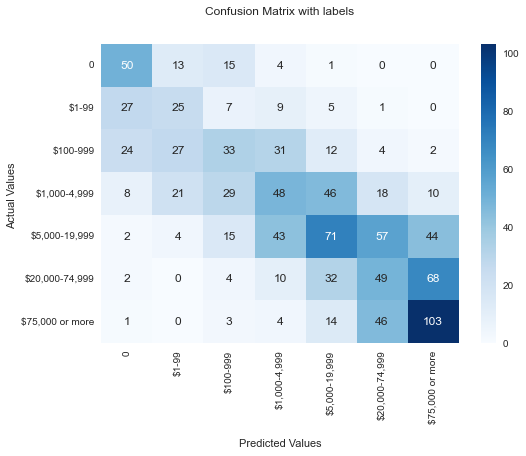

In [117]:
#confusion_matrix
conf_lgbm= confusion_matrix(target_test, y_pred_lgbm)

ax = sns.heatmap(conf_lgbm, annot=True, cmap='Blues',fmt='g')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.set_xticklabels(['0','$1-99','$100-999','$1,000-4,999','$5,000-19,999','$20,000-74,999','$75,000 or more'])
ax.set_yticklabels(['0','$1-99','$100-999','$1,000-4,999','$5,000-19,999','$20,000-74,999','$75,000 or more'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [118]:
#Save test, validation and test f1 weighted scores:
models_score['LightGBM'] = [round(lgbm.cv_results_['mean_train_score'].mean(),2),
                            round(lgbm.cv_results_['mean_test_score'].mean(),2),
                                       round(f1_score(target_test, y_pred_lgbm, average='weighted'),2)]

### Use lightGBM to exemine train vs test metrics F1 weighted

In [119]:
f1_table = {}
for i in range(1,10):
    model_lgbm = lgb.LGBMClassifier(random_state=42, max_depth=i, num_leaves=8, min_data_in_leaf=30,
                                   n_estimators=10, learning_rate=0.1)
    model_lgbm.fit(features_train_full_mice, target_train)
   
    y_pred_lgbm = model_lgbm.predict(features_test_full_mice)
    
    y_pred_lgbm_train = model_lgbm.predict(features_train_full_mice)
    
    f1_table[i] = [f1_score(target_test, y_pred_lgbm, average='weighted'),f1_score(target_train, y_pred_lgbm_train, average='weighted')]
    

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min

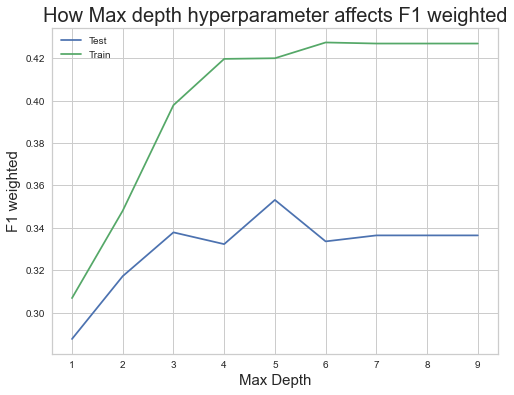

In [120]:
plt.figure(figsize=(8, 6))
plt.plot(list(f1_table.keys()),list(f1_table.values()))
plt.xlabel('Max Depth', size=15)
plt.ylabel('F1 weighted', size=15)
plt.title('How Max depth hyperparameter affects F1 weighted', size=20)
plt.legend(['Test','Train'])
plt.show()

### SVM - OvO

In [121]:
%%time

# C - Regularization parameter. The strength of the regularization is inversely proportional to C. 
# Must be strictly positive. The penalty is a squared l2 penalty.

# gamma - The gamma parameters can be seen as the inverse of the radius of influence of 
# samples selected by the model as support vectors. When gamma is very small, the model is too constrained and cannot capture 
# the complexity or “shape” of the data. 
pipe = Pipeline([('over',RandomOverSampler(random_state=12345)), ('scaler',StandardScaler()),('model',SVC())])

param_grid = {'model__C': [0.1, 1000],
              'model__gamma': [1,  0.01],
              'model__kernel': ['rbf'], 'model__probability':[True], 'model__decision_function_shape':['ovo']}

svc_ovo = best_model(pipe, param_grid, features_train_full_mice, target_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END model__C=0.1, model__decision_function_shape=ovo, model__gamma=1, model__kernel=rbf, model__probability=True;, score=(train=0.531, test=0.071) total time= 1.0min
[CV 2/5] END model__C=0.1, model__decision_function_shape=ovo, model__gamma=1, model__kernel=rbf, model__probability=True;, score=(train=0.534, test=0.071) total time=  51.0s
[CV 3/5] END model__C=0.1, model__decision_function_shape=ovo, model__gamma=1, model__kernel=rbf, model__probability=True;, score=(train=0.536, test=0.070) total time=  51.3s
[CV 4/5] END model__C=0.1, model__decision_function_shape=ovo, model__gamma=1, model__kernel=rbf, model__probability=True;, score=(train=0.534, test=0.070) total time=  41.5s
[CV 5/5] END model__C=0.1, model__decision_function_shape=ovo, model__gamma=1, model__kernel=rbf, model__probability=True;, score=(train=0.534, test=0.070) total time=  25.2s
[CV 1/5] END model__C=0.1, model__decision_function_shape=ovo, mo

In [122]:
y_pred_svc_ovo = svc_ovo.predict(features_test_full_mice)

print(classification_report(target_test, y_pred_svc_ovo, target_names=['0','$1-99','$100-999','$1,000-4,999',
                                                               '$5,000-19,999','$20,000-74,999','$75,000 or more']))

                 precision    recall  f1-score   support

              0       0.41      0.57      0.47        83
          $1-99       0.23      0.12      0.16        74
       $100-999       0.33      0.30      0.31       133
   $1,000-4,999       0.34      0.38      0.36       180
  $5,000-19,999       0.37      0.36      0.37       236
 $20,000-74,999       0.34      0.32      0.33       165
$75,000 or more       0.50      0.53      0.51       171

       accuracy                           0.38      1042
      macro avg       0.36      0.37      0.36      1042
   weighted avg       0.37      0.38      0.37      1042



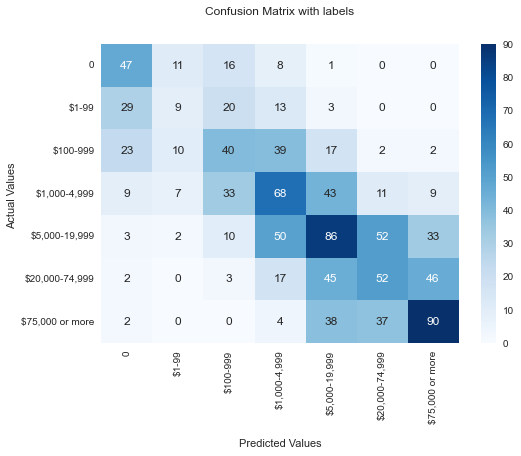

In [123]:
#confusion_matrix
conf_svc_ovo= confusion_matrix(target_test, y_pred_svc_ovo)

ax = sns.heatmap(conf_svc_ovo, annot=True, cmap='Blues',fmt='g')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.set_xticklabels(['0','$1-99','$100-999','$1,000-4,999','$5,000-19,999','$20,000-74,999','$75,000 or more'])
ax.set_yticklabels(['0','$1-99','$100-999','$1,000-4,999','$5,000-19,999','$20,000-74,999','$75,000 or more'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [124]:
#Save test, validation and test f1 weighted scores:
models_score['SVC_OvO'] = [round(svc_ovo.cv_results_['mean_train_score'].mean(),2),
                            round(svc_ovo.cv_results_['mean_test_score'].mean(),2),
                                       round(f1_score(target_test, y_pred_svc_ovo, average='weighted'),2)]

### KNN

In [125]:
pipe = Pipeline([('over',RandomOverSampler(random_state=12345)), ('scaler',StandardScaler()),('model',KNeighborsClassifier())])

param_grid = {'model__n_neighbors': list(range(10, 20))}

knn = best_model(pipe, param_grid, features_train_full_mice, target_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END model__n_neighbors=10;, score=(train=0.462, test=0.278) total time=   0.3s
[CV 2/5] END model__n_neighbors=10;, score=(train=0.464, test=0.302) total time=   0.3s
[CV 3/5] END model__n_neighbors=10;, score=(train=0.459, test=0.295) total time=   0.3s
[CV 4/5] END model__n_neighbors=10;, score=(train=0.470, test=0.292) total time=   0.3s
[CV 5/5] END model__n_neighbors=10;, score=(train=0.466, test=0.284) total time=   0.3s
[CV 1/5] END model__n_neighbors=11;, score=(train=0.462, test=0.280) total time=   0.3s
[CV 2/5] END model__n_neighbors=11;, score=(train=0.455, test=0.295) total time=   0.2s
[CV 3/5] END model__n_neighbors=11;, score=(train=0.452, test=0.295) total time=   0.2s
[CV 4/5] END model__n_neighbors=11;, score=(train=0.460, test=0.302) total time=   0.2s
[CV 5/5] END model__n_neighbors=11;, score=(train=0.450, test=0.271) total time=   0.2s
[CV 1/5] END model__n_neighbors=12;, score=(train=0.450, te

In [126]:
y_pred_knn = knn.predict(features_test_full_mice)

print(classification_report(target_test, y_pred_knn, target_names=['0','$1-99','$100-999','$1,000-4,999',
                                                               '$5,000-19,999','$20,000-74,999','$75,000 or more']))

                 precision    recall  f1-score   support

              0       0.39      0.36      0.38        83
          $1-99       0.16      0.23      0.19        74
       $100-999       0.26      0.21      0.23       133
   $1,000-4,999       0.30      0.21      0.25       180
  $5,000-19,999       0.28      0.19      0.23       236
 $20,000-74,999       0.24      0.33      0.27       165
$75,000 or more       0.41      0.54      0.47       171

       accuracy                           0.29      1042
      macro avg       0.29      0.30      0.29      1042
   weighted avg       0.29      0.29      0.29      1042



In [127]:
#Save test, validation and test f1 weighted scores:
models_score['KNN'] = [round(knn.cv_results_['mean_train_score'].mean(),2),
                            round(knn.cv_results_['mean_test_score'].mean(),2),
                                       round(f1_score(target_test, y_pred_knn, average='weighted'),2)]

## Results

In [128]:
pd.DataFrame.from_dict(models_score, orient='index', columns=['Train F1 weighted',
                                                              'Valid F1 weighted','Test F1 weighted']).sort_values(by='Test F1 weighted', ascending=False)

Train F1 weighted  Valid F1 weighted  Test F1 weighted
Logisitc Regression               0.40               0.34              0.37
SVC                               0.49               0.23              0.37
SVC_OvO                           0.74               0.20              0.37
XGBoost                           0.86               0.35              0.36
LightGBM                          0.52               0.33              0.36
RandomForest                      0.55               0.34              0.35
DecisionTree                      0.63               0.30              0.29
KNN                               0.44               0.29              0.29

## First insights

We see many clasiffication mistakes, but some of the mistakes might be accetapble, such as the differnce between people with USD 0 to USD 1-99, or USD 100 - 999 to USD 1,000 to 4,999 maybe not that far.<br><br>
Also, for example there might be people with USD 65,000 and people with USD 75,000, and appear under differnt classes.<br><br>
Maybe so many clases is too much for classification task, where the label represent too close classes. Maybe we need to divide the labels to sub categories. <br><br>
We might try start with prediction of USD 0 to USD 4,999 for lower level of saving and USD 5,000 to 19,999 to mid-level and USD 20,000 and above to higher levels of saving. <br><br>
Then we can try to dive deeper.

## Predict one class and change thresholds

### Class 0: $0

In [129]:
#Convert multi class into binary - train set
target_train_0 = [1 if x==1 else 0 for x in target_train]
target_train_0 = pd.Series(target_train_0, index=target_train.index)

#Convert multi class into binary - test set
target_test_0 = [1 if x==1 else 0 for x in target_test]
target_test_0 = pd.Series(target_test_0, index=target_test.index)

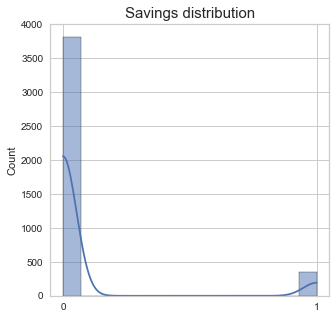

In [131]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(target_train_0, kde=True, ax=ax)
plt.title('Savings distribution', size=15)
plt.xticks(np.arange(min(target_train_0), max(target_train_0)+1, 1.0))
plt.show()

Very imbalanced data

In [132]:
pipe = Pipeline([('over',RandomOverSampler(random_state=12345)), ('model',LogisticRegression())])

log_reg_b = best_model_binary(pipe, {}, features_train_full_mice, target_train_0)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..............., score=(train=0.621, test=0.470) total time=   0.4s
[CV 2/5] END ..............., score=(train=0.592, test=0.543) total time=   0.4s
[CV 3/5] END ..............., score=(train=0.589, test=0.516) total time=   0.4s
[CV 4/5] END ..............., score=(train=0.596, test=0.526) total time=   0.4s
[CV 5/5] END ..............., score=(train=0.582, test=0.571) total time=   0.4s

Best parameters: {}

Best score: 0.53


In [133]:
y_pred_log_reg_b = log_reg_b.predict(features_test_full_mice)

print(classification_report(target_test_0, y_pred_log_reg_b))

              precision    recall  f1-score   support

           0       0.98      0.86      0.92       959
           1       0.34      0.82      0.48        83

    accuracy                           0.86      1042
   macro avg       0.66      0.84      0.70      1042
weighted avg       0.93      0.86      0.88      1042



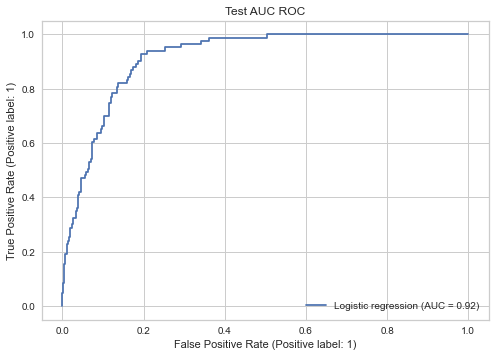

In [134]:
ax = plt.gca()
plt.title('Test AUC ROC')
metrics.plot_roc_curve(log_reg_b, features_test_full_mice, target_test_0, name = 'Logistic regression', ax=ax)
plt.show()

In [135]:
y_pred_log_reg_b_proba = log_reg_b.predict_proba(features_test_full_mice)
yhat = y_pred_log_reg_b_proba[:, 1]

In [136]:
f1_max=0
for i in np.arange(0,1,0.05):
    predicted_valid = yhat > i
    f1_sc = f1_score(target_test_0, predicted_valid)
    print('Treshold:', round(i,3) ,'f1 score:',round(f1_score(target_test_0, predicted_valid),3))
    
    if f1_sc>f1_max:
        f1_max = f1_sc
        best_treshold = i
print()        
print('Best treshold:', round(best_treshold,3) ,'best f1 score:',round(f1_max,3))

Treshold: 0.0 f1 score: 0.148
Treshold: 0.05 f1 score: 0.329
Treshold: 0.1 f1 score: 0.376
Treshold: 0.15 f1 score: 0.399
Treshold: 0.2 f1 score: 0.425
Treshold: 0.25 f1 score: 0.439
Treshold: 0.3 f1 score: 0.444
Treshold: 0.35 f1 score: 0.449
Treshold: 0.4 f1 score: 0.452
Treshold: 0.45 f1 score: 0.467
Treshold: 0.5 f1 score: 0.479
Treshold: 0.55 f1 score: 0.48
Treshold: 0.6 f1 score: 0.481
Treshold: 0.65 f1 score: 0.481
Treshold: 0.7 f1 score: 0.474
Treshold: 0.75 f1 score: 0.49
Treshold: 0.8 f1 score: 0.461
Treshold: 0.85 f1 score: 0.456
Treshold: 0.9 f1 score: 0.467
Treshold: 0.95 f1 score: 0.397

Best treshold: 0.75 best f1 score: 0.49


In [137]:
predicted_valid = yhat > best_treshold
print(classification_report(target_test_0, predicted_valid))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       959
           1       0.41      0.61      0.49        83

    accuracy                           0.90      1042
   macro avg       0.69      0.77      0.72      1042
weighted avg       0.92      0.90      0.91      1042



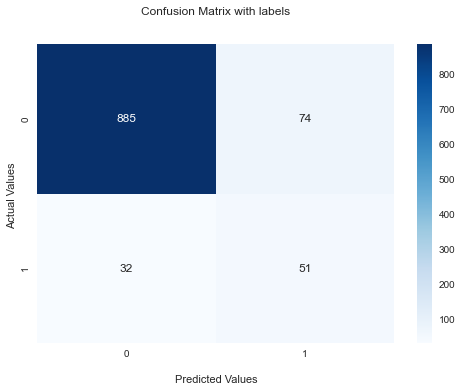

In [138]:
#confusion_matrix
conf_log_b= confusion_matrix(target_test_0, predicted_valid)

ax = sns.heatmap(conf_log_b, annot=True, cmap='Blues',fmt='g')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
plt.show()

For the best F1 score 49%:

Recall 61% - The model was able to recognize only 61% of all cases.
We see that the model predicted 51 correct 1 classes, but for the rest of 32 class 1 cases (USD 0 saving) he predicted that they have more money, althou they have not. <br>

Precision 41% - The predictions of the model were right in only 41%. We see that 51 class 1 cases were predicted correctly but 74 classes were labeld as class 1 (USD 0 savings), but actually they had more more money.

If people with 0 savings are very important to recognize (for business they have higher risk, for education they need more attention), even in the case of mistake, we want the model to predict more cases of USD 0. In this case we would like to increse the Recall on the expense of saying people have mo money when they actually have. 

In [139]:
recall_max=0
for i in np.arange(0,1,0.05):
    predicted_valid = yhat > i
    recall_sc = recall_score(target_test_0, predicted_valid)
    print('Treshold:', round(i,3) ,'recall score:',round(recall_score(target_test_0, predicted_valid),3))
    
    if recall_sc>recall_max:
        recall_max = recall_sc
        best_treshold_r = i
print()        
print('Best treshold:', round(best_treshold_r,3) ,'best recall score:',round(recall_max,3))

Treshold: 0.0 recall score: 1.0
Treshold: 0.05 recall score: 0.976
Treshold: 0.1 recall score: 0.952
Treshold: 0.15 recall score: 0.94
Treshold: 0.2 recall score: 0.94
Treshold: 0.25 recall score: 0.904
Treshold: 0.3 recall score: 0.892
Treshold: 0.35 recall score: 0.867
Treshold: 0.4 recall score: 0.831
Treshold: 0.45 recall score: 0.819
Treshold: 0.5 recall score: 0.819
Treshold: 0.55 recall score: 0.783
Treshold: 0.6 recall score: 0.747
Treshold: 0.65 recall score: 0.699
Treshold: 0.7 recall score: 0.663
Treshold: 0.75 recall score: 0.614
Treshold: 0.8 recall score: 0.53
Treshold: 0.85 recall score: 0.494
Treshold: 0.9 recall score: 0.47
Treshold: 0.95 recall score: 0.325

Best treshold: 0.0 best recall score: 1.0


We don't want the model to predict all customers as class 1, so we won't use 0 as a treshold.

              precision    recall  f1-score   support

           0       0.99      0.79      0.88       959
           1       0.27      0.94      0.43        83

    accuracy                           0.80      1042
   macro avg       0.63      0.86      0.65      1042
weighted avg       0.94      0.80      0.84      1042



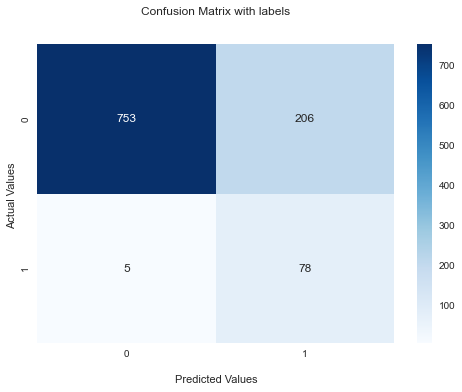

In [140]:
predicted_valid = yhat > 0.2
print(classification_report(target_test_0, predicted_valid))

#confusion_matrix
conf_log_b= confusion_matrix(target_test_0, predicted_valid)

ax = sns.heatmap(conf_log_b, annot=True, cmap='Blues',fmt='g')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
plt.show()

Precision 27%. The model predicted correctly only 27% of the cases.

Recall 94%. the model was able to recognize 94% of the cases.

In total 72% of models predictions were false alarms. In this case, 206 people would have to investigated further (maybe they have small amount of savings). But only 5 people were missed. 78 people were correctly detected as have 0 savings, and 753 (78%) were detected correctly as have more than USD 0 savings.

## Predict 3 classes - Low, Mid, High

In [192]:
#Create empty tuple for score
models_score_3 = {}

1. USD 0 - Low
2. USD 1-99 - Low
3. USD 100-999 - Low
4. USD 1,000-4,999 - Mid
5. USD 5,000-19,999 - Mid
6. USD 20,000-74,999 - High
7. USD 75,000 or more - High

In [153]:
#Convert 7 classes into 3 classes - train set
target_train_3 = [1 if x==1 else 1 if x==2 else 1 if x==3 else 2 if x==4 else 2 if x==5 else 3 if x==6 else 3 for x in target_train]
target_train_3 = pd.Series(target_train_3, index=target_train.index)

#Convert 7 classes into 3 classes - test set
target_test_3 = [1 if x==1 else 1 if x==2 else 1 if x==3 else 2 if x==4 else 2 if x==5 else 3 if x==6 else 3 for x in target_test]
target_test_3 = pd.Series(target_test_3, index=target_test.index)

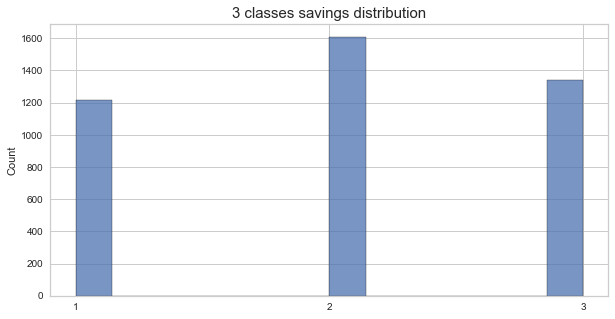

In [158]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(target_train_3, ax=ax)
plt.title('3 classes savings distribution', size=15)
plt.xticks(np.arange(min(target_train_3), max(target_train_3)+1, 1.0))
plt.show()

The seems more balance than not.

### Logistic regression

In [159]:
pipe = Pipeline([('model',LogisticRegression())])

log_reg_3 = best_model(pipe, {}, features_train_full_mice, target_train_3)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..............., score=(train=0.703, test=0.685) total time=   0.2s
[CV 2/5] END ..............., score=(train=0.704, test=0.653) total time=   0.1s
[CV 3/5] END ..............., score=(train=0.703, test=0.666) total time=   0.2s
[CV 4/5] END ..............., score=(train=0.703, test=0.663) total time=   0.2s
[CV 5/5] END ..............., score=(train=0.689, test=0.700) total time=   0.2s

Best parameters: {}

Best score: 0.67


In [161]:
y_pred_lr_3 = log_reg_3.predict(features_test_full_mice)

In [162]:
print(classification_report(target_test_3, y_pred_lr_3, target_names=['Low',
                                                               'Mid','High']))

              precision    recall  f1-score   support

         Low       0.77      0.73      0.75       290
         Mid       0.62      0.61      0.61       416
        High       0.69      0.74      0.71       336

    accuracy                           0.68      1042
   macro avg       0.69      0.69      0.69      1042
weighted avg       0.69      0.68      0.68      1042



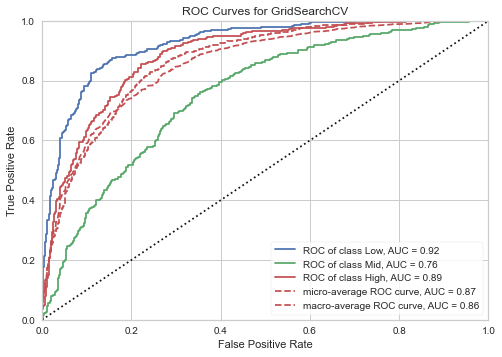

In [165]:
visual_3 = plot_ROC_curve_3(log_reg_3, features_train_full_mice, target_train_3, features_test_full_mice, target_test_3)

In [193]:
#Save f1 weighted scores:
models_score_3['Logistic_regression'] = [round(log_reg_3.cv_results_['mean_train_score'].mean(),2),
                            round(log_reg_3.cv_results_['mean_test_score'].mean(),2),
                                       round(f1_score(target_test_3, y_pred_lr_3, average='weighted'),2)]

### SVC

In [178]:
%%time

# C - Regularization parameter. The strength of the regularization is inversely proportional to C. 
# Must be strictly positive. The penalty is a squared l2 penalty.

# gamma - The gamma parameters can be seen as the inverse of the radius of influence of 
# samples selected by the model as support vectors. When gamma is very small, the model is too constrained and cannot capture 
# the complexity or “shape” of the data.  
#Gamma essentially controls the distance of influence of a single training point.
#-Low values of Gamma indicate a large similarity radius which results in more points being grouped together.
#-For High values of Gamma, the points need to be very close to each other in order for it to be considered in the same group.


pipe = Pipeline([('scaler',StandardScaler()),('model',SVC())])

param_grid = {'model__C': [1, 1.5],
              'model__gamma':[0.005, 0.01,'scale','auto'],
              'model__kernel': ['rbf'], 'model__probability':[True]}

svc_3 = best_model(pipe, param_grid, features_train_full_mice, target_train_3)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END model__C=1, model__gamma=0.005, model__kernel=rbf, model__probability=True;, score=(train=0.840, test=0.680) total time=   4.0s
[CV 2/5] END model__C=1, model__gamma=0.005, model__kernel=rbf, model__probability=True;, score=(train=0.843, test=0.666) total time=   3.8s
[CV 3/5] END model__C=1, model__gamma=0.005, model__kernel=rbf, model__probability=True;, score=(train=0.835, test=0.690) total time=   5.4s
[CV 4/5] END model__C=1, model__gamma=0.005, model__kernel=rbf, model__probability=True;, score=(train=0.836, test=0.684) total time=   5.1s
[CV 5/5] END model__C=1, model__gamma=0.005, model__kernel=rbf, model__probability=True;, score=(train=0.842, test=0.700) total time=   5.4s
[CV 1/5] END model__C=1, model__gamma=0.01, model__kernel=rbf, model__probability=True;, score=(train=0.932, test=0.665) total time=   8.3s
[CV 2/5] END model__C=1, model__gamma=0.01, model__kernel=rbf, model__probability=True;, score=

In [179]:
y_pred_svc_3 = svc_3.predict(features_test_full_mice)


print(classification_report(target_test_3, y_pred_svc_3, target_names=['Low',
                                                               'Mid','High']))

              precision    recall  f1-score   support

         Low       0.77      0.74      0.76       290
         Mid       0.62      0.61      0.62       416
        High       0.70      0.74      0.72       336

    accuracy                           0.69      1042
   macro avg       0.70      0.70      0.70      1042
weighted avg       0.69      0.69      0.69      1042



In [194]:
#Save f1 weighted scores:
models_score_3['SVC'] = [round(svc_3.cv_results_['mean_train_score'].mean(),2),
                            round(svc_3.cv_results_['mean_test_score'].mean(),2),
                                       round(f1_score(target_test_3, y_pred_svc_3, average='weighted'),2)]

### Random Forest

In [180]:
%%time
# n_estimators - This is the number of trees
# max_depth - The maximum depth of the tree. Need to restriced to avoid overfitting
pipe = Pipeline([('model',RandomForestClassifier(random_state=12345))])

rf_3 = best_model(pipe, {'model__n_estimators' : [100, 200],
                        'model__max_depth' : [5,8],
                      'model__min_samples_split':[10, 20],
                      'model__min_samples_leaf':[10,20]}, features_train_full_mice, target_train_3)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END model__max_depth=5, model__min_samples_leaf=10, model__min_samples_split=10, model__n_estimators=100;, score=(train=0.701, test=0.653) total time=   0.4s
[CV 2/5] END model__max_depth=5, model__min_samples_leaf=10, model__min_samples_split=10, model__n_estimators=100;, score=(train=0.707, test=0.658) total time=   0.3s
[CV 3/5] END model__max_depth=5, model__min_samples_leaf=10, model__min_samples_split=10, model__n_estimators=100;, score=(train=0.703, test=0.670) total time=   0.3s
[CV 4/5] END model__max_depth=5, model__min_samples_leaf=10, model__min_samples_split=10, model__n_estimators=100;, score=(train=0.710, test=0.671) total time=   0.3s
[CV 5/5] END model__max_depth=5, model__min_samples_leaf=10, model__min_samples_split=10, model__n_estimators=100;, score=(train=0.703, test=0.663) total time=   0.3s
[CV 1/5] END model__max_depth=5, model__min_samples_leaf=10, model__min_samples_split=10, model__n_estim

In [181]:
y_pred_rf_3 = rf_3.predict(features_test_full_mice)


print(classification_report(target_test_3, y_pred_rf_3, target_names=['Low',
                                                               'Mid','High']))

              precision    recall  f1-score   support

         Low       0.79      0.73      0.76       290
         Mid       0.61      0.63      0.62       416
        High       0.70      0.71      0.71       336

    accuracy                           0.69      1042
   macro avg       0.70      0.69      0.70      1042
weighted avg       0.69      0.69      0.69      1042



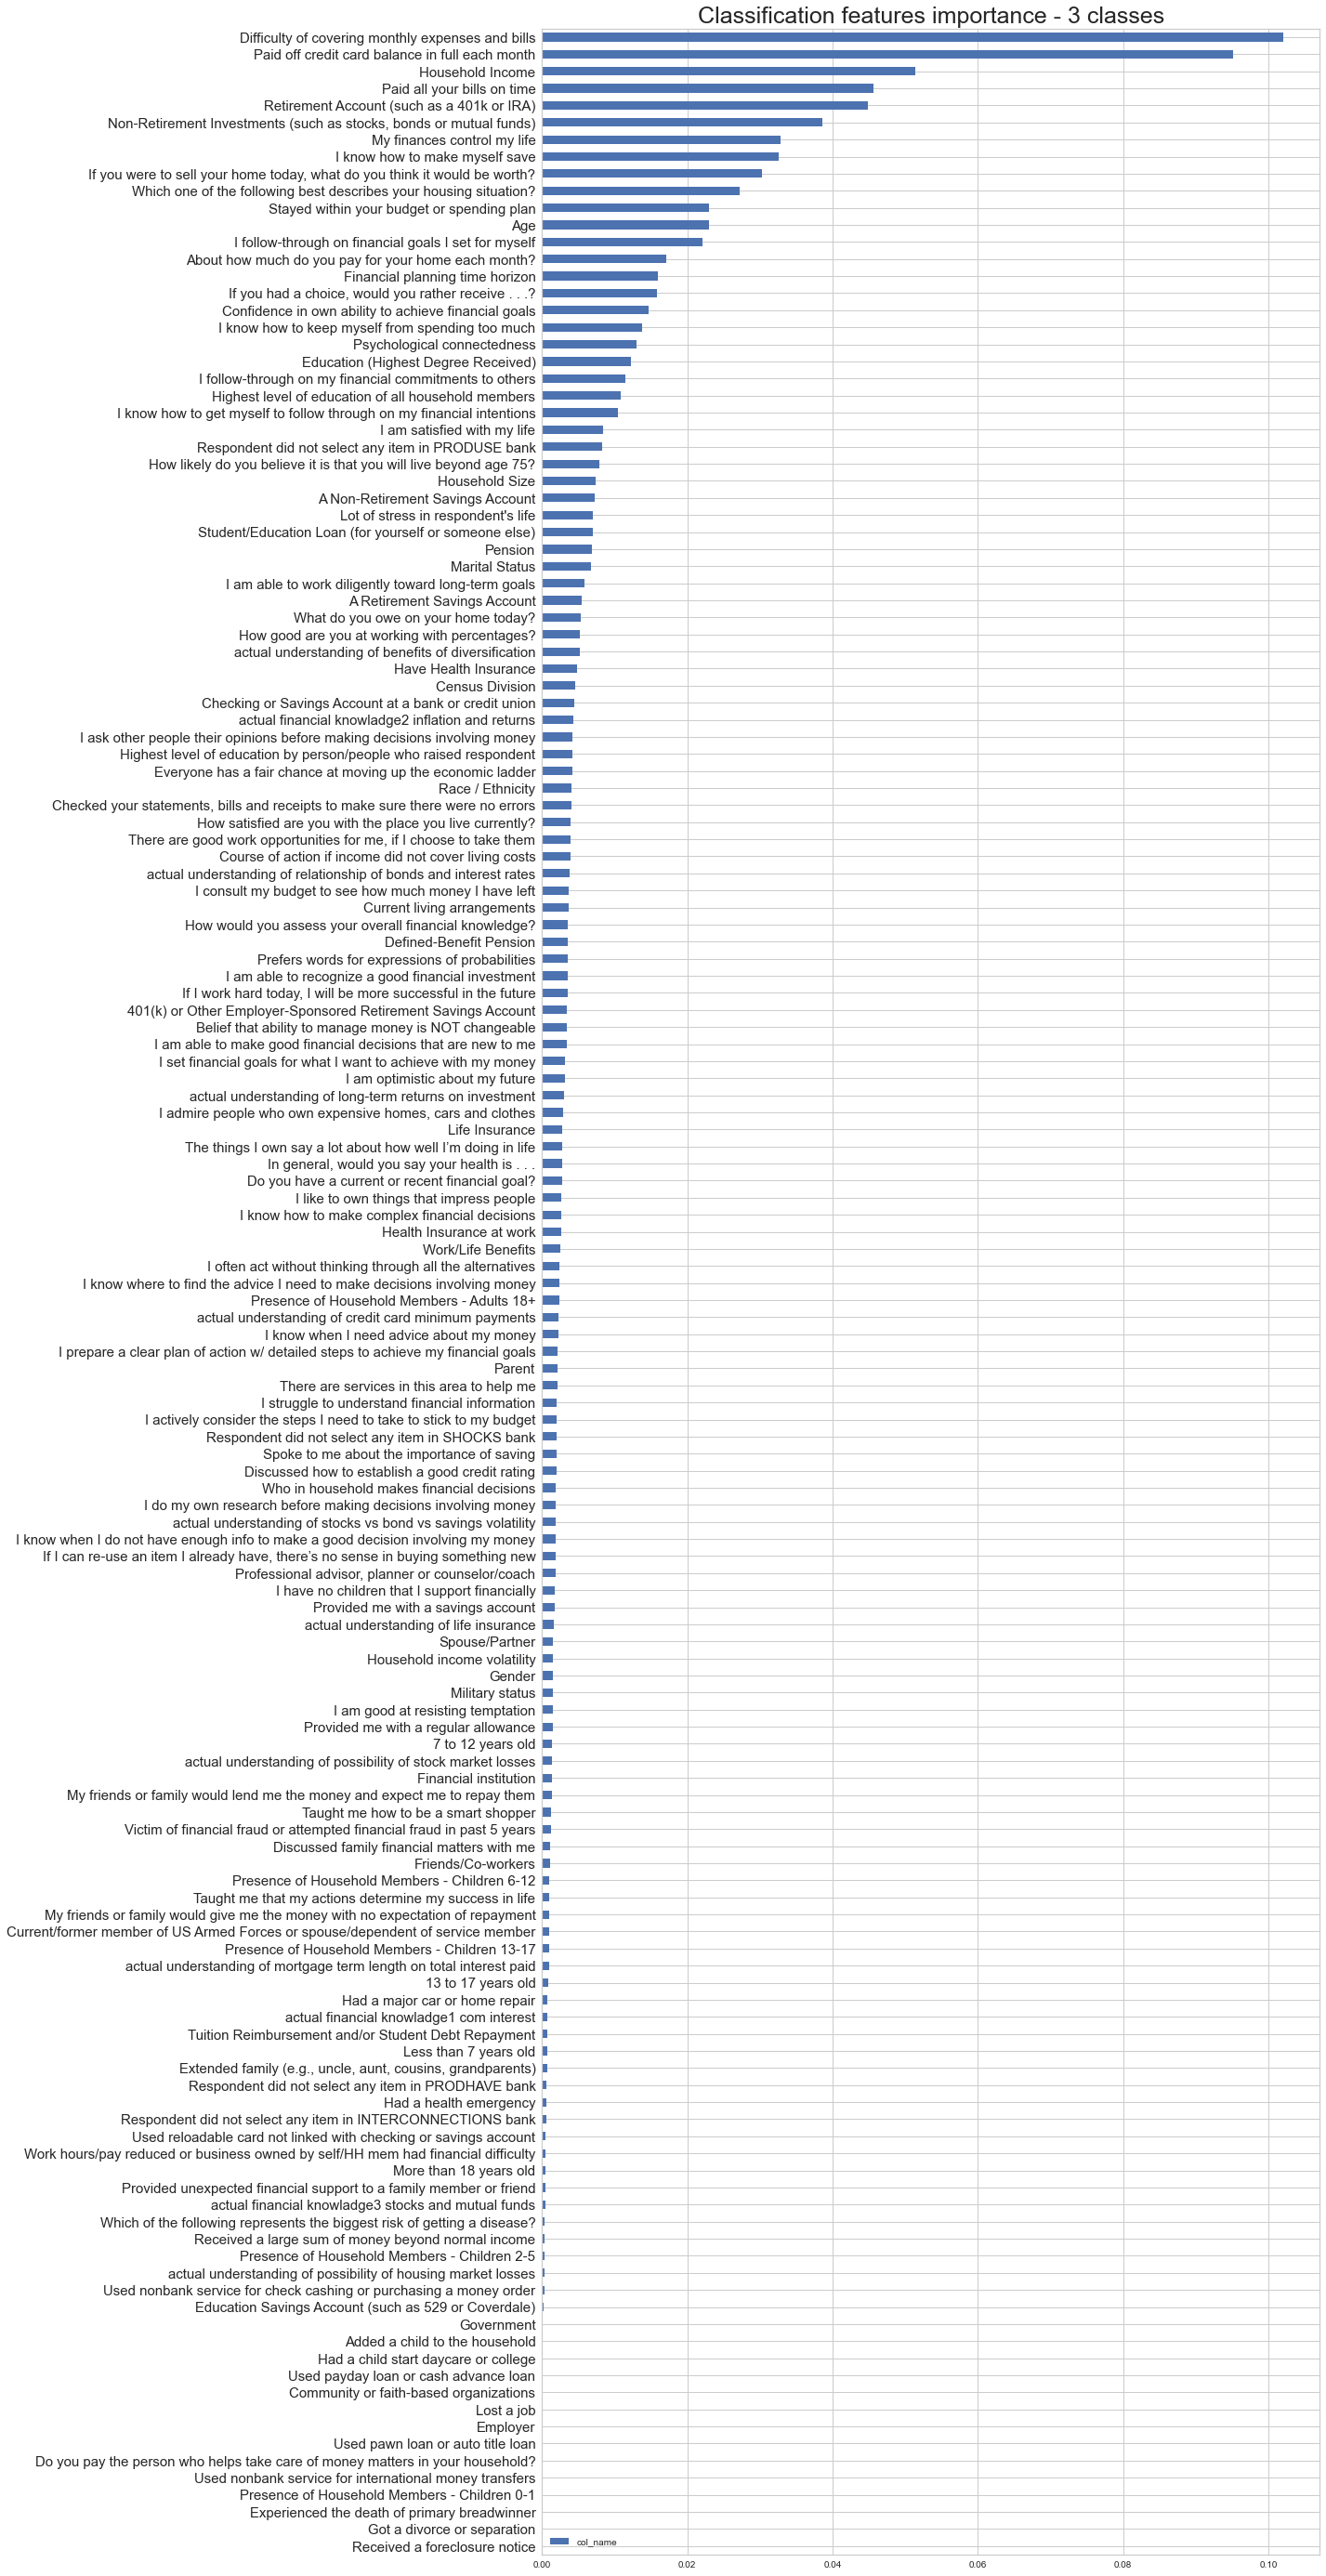

In [188]:
feature_importance_3_classes = pd.DataFrame({'col_name': rf_3.best_estimator_[0].feature_importances_}, index=features_train_all.columns).sort_values(by='col_name', ascending=False)

fig, ax = plt.subplots(figsize =(15, 50))
feature_importance_3_classes.sort_values(by='col_name',ascending=True).plot(kind='barh', ax=ax)
plt.title('Classification features importance - 3 classes', size=25)
ax.tick_params(axis='y', labelsize=15)
plt.show()

In [189]:
%%time
#See explanation for test set
explainer_3 = shap.TreeExplainer(rf_3.best_estimator_[0])
shap_values_3 = explainer_3.shap_values(features_test_full_mice)

Wall time: 7.61 s


Class: Low


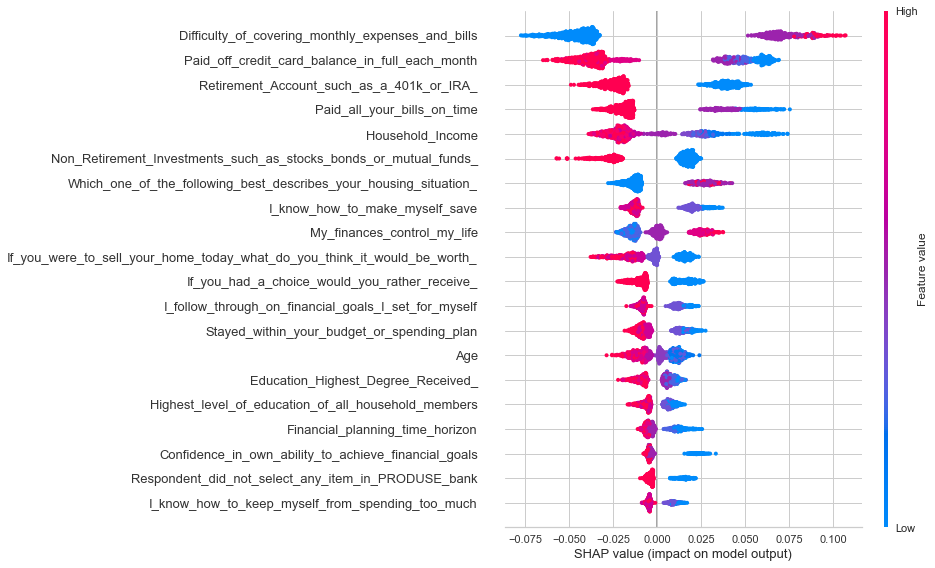

Class: Mid


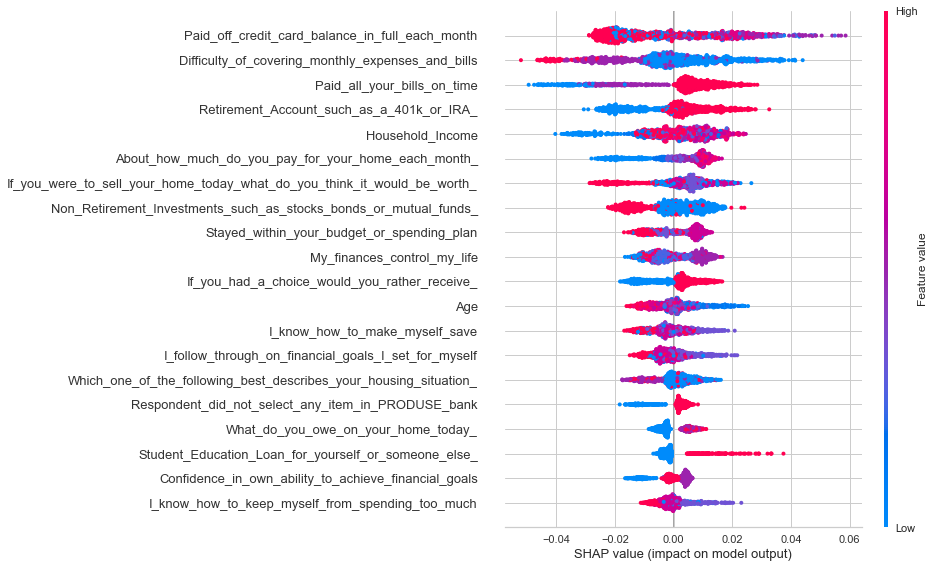

Class: High


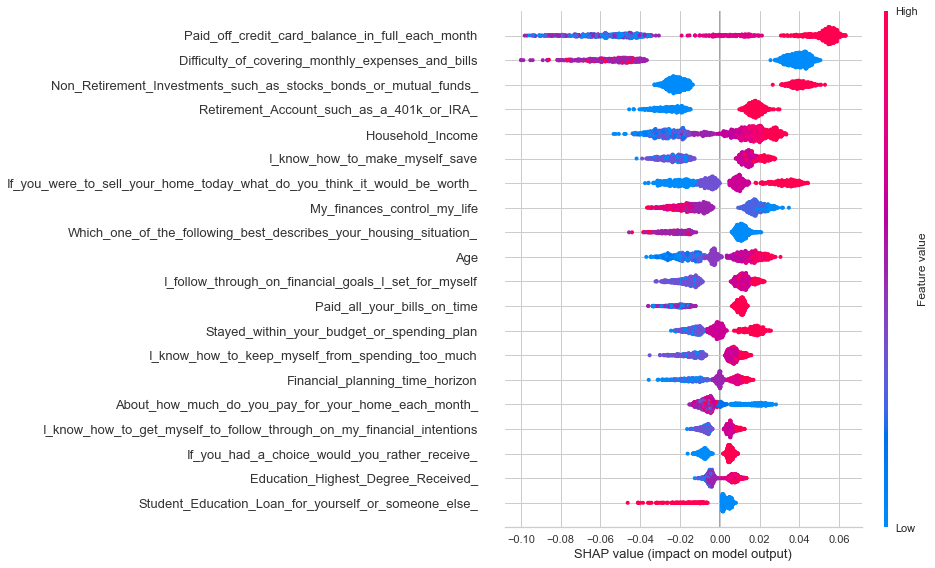

In [191]:
classes_3={1: 'Low',
2: 'Mid', 
3: 'High'}

for i in range(1,4):
    print('Class:', classes_3[i])
    shap.summary_plot(shap_values_3[i-1], features_test_full_mice.values, feature_names = features_test_full_mice.columns)

In [195]:
#Save f1 weighted scores:
models_score_3['Random_forest'] = [round(rf_3.cv_results_['mean_train_score'].mean(),2),
                            round(rf_3.cv_results_['mean_test_score'].mean(),2),
                                       round(f1_score(target_test_3, y_pred_rf_3, average='weighted'),2)]

## 3 Classes results

In [196]:
pd.DataFrame.from_dict(models_score_3, orient='index', columns=['Train F1 weighted',
                                                              'Valid F1 weighted','Test F1 weighted']).sort_values(by='Test F1 weighted', ascending=False)

Train F1 weighted  Valid F1 weighted  Test F1 weighted
SVC                               0.90               0.68              0.69
Random_forest                     0.73               0.67              0.69
Logistic_regression               0.70               0.67              0.68

## Clustering - Kmeans

In this part we are going to try cluster observations with Kmeans and examine f1 score. Then we will try to use the output as a feature.

In [198]:
from sklearn.cluster import KMeans

In [205]:
kmeans_mdoel = KMeans(n_clusters=3, random_state=42)

In [206]:
kmeans_mdoel.fit(features_train_full_mice)

KMeans(n_clusters=3, random_state=42)

In [214]:
print(np.unique(kmeans_mdoel.labels_+1))

[1 2 3]


In [223]:
print(kmeans_mdoel.labels_+1)

[1 1 1 ... 2 1 3]


In [260]:
train_cluster = pd.Series(data = kmeans_mdoel.labels_+1, index = target_train_3.index)

In [261]:
cluster_pred = kmeans_mdoel.predict(features_test_full_mice)

test_cluster = pd.Series(data = cluster_pred+1, index = target_test_3.index)

In [253]:
#Train f1 weighted score
f1_score(train_cluster, target_train_3, average='weighted')

0.20581944163117022

In [254]:
#Test f1 weighted score
f1_score(test_cluster, target_test_3, average='weighted')

0.2294073335099913

In [255]:
#Add cluster feature to train set
features_train_cluster = features_train_full_mice.merge(train_cluster.rename('features_train_cluster'), left_index=True, right_index=True)

#Add cluster feature to test set
features_test_cluster = features_test_full_mice.merge(test_cluster.rename('features_test_cluster'), left_index=True, right_index=True)

### SVC with cluster feature

In [257]:
svc_3.best_params_

{'model__C': 1,
 'model__gamma': 0.005,
 'model__kernel': 'rbf',
 'model__probability': True}

In [258]:
%%time

# C - Regularization parameter. The strength of the regularization is inversely proportional to C. 
# Must be strictly positive. The penalty is a squared l2 penalty.

# gamma - The gamma parameters can be seen as the inverse of the radius of influence of 
# samples selected by the model as support vectors. When gamma is very small, the model is too constrained and cannot capture 
# the complexity or “shape” of the data.  
#Gamma essentially controls the distance of influence of a single training point.
#-Low values of Gamma indicate a large similarity radius which results in more points being grouped together.
#-For High values of Gamma, the points need to be very close to each other in order for it to be considered in the same group.


pipe = Pipeline([('scaler',StandardScaler()),('model',SVC())])

param_grid = {'model__C': [1],
              'model__gamma':[0.005],
              'model__kernel': ['rbf'], 'model__probability':[True]}

svc_3_cluster = best_model(pipe, param_grid, features_train_cluster, target_train_3)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END model__C=1, model__gamma=0.005, model__kernel=rbf, model__probability=True;, score=(train=0.842, test=0.676) total time=   5.6s
[CV 2/5] END model__C=1, model__gamma=0.005, model__kernel=rbf, model__probability=True;, score=(train=0.844, test=0.661) total time=   5.3s
[CV 3/5] END model__C=1, model__gamma=0.005, model__kernel=rbf, model__probability=True;, score=(train=0.835, test=0.691) total time=   7.3s
[CV 4/5] END model__C=1, model__gamma=0.005, model__kernel=rbf, model__probability=True;, score=(train=0.838, test=0.688) total time=   6.8s
[CV 5/5] END model__C=1, model__gamma=0.005, model__kernel=rbf, model__probability=True;, score=(train=0.843, test=0.695) total time=   6.5s

Best parameters: {'model__C': 1, 'model__gamma': 0.005, 'model__kernel': 'rbf', 'model__probability': True}

Best score: 0.68
Wall time: 51.7 s


In [259]:
y_pred_svc_3_cluster = svc_3_cluster.predict(features_test_cluster)


print(classification_report(target_test_3, y_pred_svc_3_cluster, target_names=['Low',
                                                               'Mid','High']))

              precision    recall  f1-score   support

         Low       0.78      0.74      0.76       290
         Mid       0.63      0.62      0.62       416
        High       0.70      0.74      0.72       336

    accuracy                           0.69      1042
   macro avg       0.70      0.70      0.70      1042
weighted avg       0.69      0.69      0.69      1042



No improvment

In [270]:
features_test_cluster['Difficulty_of_covering_monthly_expenses_and_bills']

3259    1.0
1015    1.0
1422    1.0
2550    1.0
4469    2.0
       ... 
3599    1.0
5593    2.0
971     2.0
5298    2.0
206     2.0
Name: Difficulty_of_covering_monthly_expenses_and_bills, Length: 1042, dtype: float64

### Clustering - Kmodes

In [275]:
from kmodes.kmodes import KModes

In [ ]:
km = KModes(n_clusters=3, init='Huang', n_init=5, verbose=1)

km_clusters = km.fit_predict(features_train_full_mice)

In [299]:
np.unique(km_clusters+1)

array([1, 2, 3], dtype=uint16)

In [284]:
#Train f1 weighted score
f1_score(km_clusters+1, target_train_3, average='weighted')

0.5316136731110829

In [285]:
test_cluster_kmodes = km.predict(features_test_full_mice)

In [287]:
#Test f1 weighted score
f1_score(test_cluster_kmodes+1, target_test_3, average='weighted')

0.5101266921367186

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 58712.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 58712.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 58712.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 58712.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 58712.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 188, cost: 55469.0
Run 1, iteration: 2/100, moves: 75, cost: 55378.0
Run 1, iteration: 3/100, moves: 35, cost: 55362.0
Run 1, iteration: 4/100, moves: 10, cost: 55362.0
Init: initializing centroids
Init: initializing clus

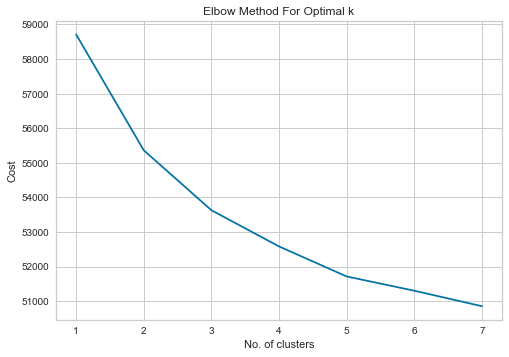

In [288]:
# Elbow curve to find optimal K
cost = []
K = range(1,8)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(features_test_full_mice)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

We can see bend at 5, we will use it as a feature.

In [300]:
km = KModes(n_clusters=5, init='Huang', n_init=5, verbose=1)

km_clusters = km.fit_predict(features_train_full_mice)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1919, cost: 213313.0
Run 1, iteration: 2/100, moves: 669, cost: 211627.0
Run 1, iteration: 3/100, moves: 636, cost: 210891.0
Run 1, iteration: 4/100, moves: 301, cost: 210761.0
Run 1, iteration: 5/100, moves: 51, cost: 210742.0
Run 1, iteration: 6/100, moves: 74, cost: 210669.0
Run 1, iteration: 7/100, moves: 58, cost: 210669.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1773, cost: 212428.0
Run 2, iteration: 2/100, moves: 795, cost: 211386.0
Run 2, iteration: 3/100, moves: 295, cost: 211289.0
Run 2, iteration: 4/100, moves: 60, cost: 211289.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 2077, cost: 211343.0
Run 3, iteration: 2/100, moves: 702, cost: 210721.0
Run 3, iteration: 3/100, moves: 137, cost: 210721.0
Init: initializing centroids
Init

In [301]:
np.unique(km_clusters)

array([0, 1, 2, 3, 4], dtype=uint16)

In [302]:
test_cluster_kmodes = km.predict(features_test_full_mice)

In [303]:
#Create series with train clusters
train_cluster_km = pd.Series(data = km.labels_, index = target_train_3.index)

In [304]:
#Create series with test clusters
test_cluster_km = pd.Series(data = test_cluster_kmodes, index = target_test_3.index)

In [305]:
#Add cluster feature to train set
features_train_cluster_km = features_train_full_mice.merge(train_cluster.rename('features_train_cluster_km'), left_index=True, right_index=True)

#Add cluster feature to test set
features_test_cluster_km = features_test_full_mice.merge(test_cluster.rename('features_train_cluster_km'), left_index=True, right_index=True)

### SVM with Kmodes feature

In [306]:
%%time

# C - Regularization parameter. The strength of the regularization is inversely proportional to C. 
# Must be strictly positive. The penalty is a squared l2 penalty.

# gamma - The gamma parameters can be seen as the inverse of the radius of influence of 
# samples selected by the model as support vectors. When gamma is very small, the model is too constrained and cannot capture 
# the complexity or “shape” of the data.  
#Gamma essentially controls the distance of influence of a single training point.
#-Low values of Gamma indicate a large similarity radius which results in more points being grouped together.
#-For High values of Gamma, the points need to be very close to each other in order for it to be considered in the same group.


pipe = Pipeline([('scaler',StandardScaler()),('model',SVC())])

param_grid = {'model__C': [1],
              'model__gamma':[0.005],
              'model__kernel': ['rbf'], 'model__probability':[True]}

svc_3_cluster_km = best_model(pipe, param_grid, features_train_cluster_km, target_train_3)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END model__C=1, model__gamma=0.005, model__kernel=rbf, model__probability=True;, score=(train=0.842, test=0.676) total time=   6.1s
[CV 2/5] END model__C=1, model__gamma=0.005, model__kernel=rbf, model__probability=True;, score=(train=0.844, test=0.661) total time=   5.5s
[CV 3/5] END model__C=1, model__gamma=0.005, model__kernel=rbf, model__probability=True;, score=(train=0.835, test=0.691) total time=   6.0s
[CV 4/5] END model__C=1, model__gamma=0.005, model__kernel=rbf, model__probability=True;, score=(train=0.838, test=0.688) total time=   5.6s
[CV 5/5] END model__C=1, model__gamma=0.005, model__kernel=rbf, model__probability=True;, score=(train=0.843, test=0.695) total time=   6.0s

Best parameters: {'model__C': 1, 'model__gamma': 0.005, 'model__kernel': 'rbf', 'model__probability': True}

Best score: 0.68
Wall time: 48 s


In [309]:
y_pred_svc_3_cluster_km = svc_3_cluster_km.predict(features_test_cluster_km)


print(classification_report(target_test_3, y_pred_svc_3_cluster_km, target_names=['Low',
                                                               'Mid','High']))

              precision    recall  f1-score   support

         Low       0.78      0.74      0.76       290
         Mid       0.63      0.62      0.62       416
        High       0.70      0.74      0.72       336

    accuracy                           0.69      1042
   macro avg       0.70      0.70      0.70      1042
weighted avg       0.69      0.69      0.69      1042



### Random forest with Kmode feature

In [308]:
%%time
# n_estimators - This is the number of trees
# max_depth - The maximum depth of the tree. Need to restriced to avoid overfitting
pipe = Pipeline([('model',RandomForestClassifier(random_state=12345))])

rf_3_km = best_model(pipe, {'model__n_estimators' : [100, 200],
                        'model__max_depth' : [5,8],
                      'model__min_samples_split':[10, 20],
                      'model__min_samples_leaf':[10,20]}, features_train_cluster_km, target_train_3)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END model__max_depth=5, model__min_samples_leaf=10, model__min_samples_split=10, model__n_estimators=100;, score=(train=0.702, test=0.660) total time=   0.2s
[CV 2/5] END model__max_depth=5, model__min_samples_leaf=10, model__min_samples_split=10, model__n_estimators=100;, score=(train=0.707, test=0.658) total time=   0.2s
[CV 3/5] END model__max_depth=5, model__min_samples_leaf=10, model__min_samples_split=10, model__n_estimators=100;, score=(train=0.703, test=0.675) total time=   0.3s
[CV 4/5] END model__max_depth=5, model__min_samples_leaf=10, model__min_samples_split=10, model__n_estimators=100;, score=(train=0.706, test=0.662) total time=   0.3s
[CV 5/5] END model__max_depth=5, model__min_samples_leaf=10, model__min_samples_split=10, model__n_estimators=100;, score=(train=0.704, test=0.667) total time=   0.3s
[CV 1/5] END model__max_depth=5, model__min_samples_leaf=10, model__min_samples_split=10, model__n_estim

In [310]:
y_pred_rf_3_km = rf_3_km.predict(features_test_cluster_km)


print(classification_report(target_test_3, y_pred_rf_3_km, target_names=['Low',
                                                               'Mid','High']))

              precision    recall  f1-score   support

         Low       0.78      0.74      0.76       290
         Mid       0.61      0.64      0.62       416
        High       0.71      0.71      0.71       336

    accuracy                           0.69      1042
   macro avg       0.70      0.69      0.70      1042
weighted avg       0.69      0.69      0.69      1042



No improvment

## Neural Networks

## Feature selection - Chi-Squared Feature Selection | Mutual Information Feature Selection

## Next steps?

2. Predict subcategories - low, mid, high
2. Regularizations/Simplification
2. Clustering as feature engineering.<br>
3. Try to remove strong features
4. Add features

**Nikolay**<br>
1. Change threshold 0 - 1 to find max f1 results
2. Logistic regression check each class separetly, see how the results changes.
3. Nural networks with one or two layers. Fully Connected with 10 nodes.
4. Regularization for models, much simpler
5. KNN
6. FAISS - facebook model
7. Try clustering